# **Complex Networks - A3**

## **Topological and Modular Analysis of Semantic Networks in Alzheimer’s Disease: Community Structure, Modularity, and Network Reorganization**

**ROADMAP**:

* Observe the contents of the dataset

* Reproduce the results from the file: paramater_metrics_networks.json

* Perform community analysis

* Associate animals with nodes to dissect the community analysis

* Propose a new approach for organizing this dataset







In [18]:
import os
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
import graph_tool.all as gt
from infomap import Infomap

from adjustText import adjust_text
from collections import Counter

from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score, confusion_matrix, accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.cluster import SpectralClustering, AgglomerativeClustering
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import LeaveOneOut



## 1 Graph Metrics Extraction

In [ ]:
def load_pickle_content(path):
    """
    Function to load pickle files.
    """
    with open(path, 'rb') as f:
        return pickle.load(f, encoding='latin1')

: 

In [ ]:
def binarize_adj(A: np.ndarray, threshold: float = 0.0) -> np.ndarray:
    """
    Binarizes the adjacency matrix based on a threshold.
    Ensures the diagonal is zero (no self-loops).
    """
    A = np.asarray(A)
    B = (A > threshold).astype(np.uint8)
    # remove self-loops if any
    np.fill_diagonal(B, 0)
    return B

: 

In [ ]:
def adj_to_graph(B: np.ndarray) -> nx.Graph:
    """
    Converts a binary adjacency matrix to NetworkX graph.
    """
    # NetworkX uses nodes 0..n-1
    return nx.from_numpy_array(B)

: 

In [ ]:
def get_graph_metrics(A: np.ndarray, threshold: float = 0.0) -> dict:
    """
    Takes an Adjacency Matrix, converts it to a Graph, and computes metrics.
    """

    B = binarize_adj(A, threshold=threshold)
    G = adj_to_graph(B)

    # Componente gigante para métricas de distancia
    if nx.is_connected(G):
        G_connected = G
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_connected = G.subgraph(largest_cc).copy()

    # Métricas
    degrees = [d for n, d in G.degree()]

    metrics = {
        'num_nodes': G.number_of_nodes(),
        'num_edges': G.number_of_edges(),
        'avg_degree': np.mean(degrees),
        'median_degree': np.median(degrees),
        'clustering': nx.average_clustering(G),
        'density': nx.density(G),
        'largest_component_size': len(G_connected)
    }

    try:
        metrics['diameter'] = nx.diameter(G_connected)
        metrics['spl'] = nx.average_shortest_path_length(G_connected)
    except:
        metrics['diameter'] = 0
        metrics['spl'] = 0

    return metrics

: 

In [ ]:
folder_path = "../Datasets/Networks"
files = []

try:
    for filename in os.listdir(folder_path):
        if filename.endswith(".pickle"):
            full_path = os.path.join(folder_path, filename)
            files.append(filename)
    print(f"{len(files)} files to process.")
except:
    print(f"Error: Folder '{folder_path}' does not exist.")
    files = []

files

102 files to process.


['ucsd_ad_graphs_usf_persev.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_0.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_1.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_10.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_11.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_12.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_13.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_14.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_15.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_16.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_17.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_18.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_19.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_2.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_20.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_21.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_22.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_23.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_24.pickle',
 'ucsd_ad_graphs_usf_persev_shuffled_25.pickle',
 'ucsd_ad_graphs_usf_persev_shuffle

: 

In [ ]:
folder_path = "../Datasets/Networks/"
group_files = {
    'AD': 'ucsd_ad_graphs_usf_persev',
    'NC': 'ucsd_nc_graphs_usf_persev'
}

final_data = []

for group_name, file_name in group_files.items():

    print(f"\n Processing {group_name} Real Network...")

    # 1. Load the ORIGINAL (Real) Data File
    original_path = os.path.join(folder_path, f"{file_name}.pickle")

    if not os.path.exists(original_path):
        print(f"ERROR: Original file not found: {original_path}")
        continue

    data_orig = load_pickle_content(original_path)
    print(f"Loaded {len(data_orig['subs'])} subjects from the original file.")

    # Initialize results dictionary
    subjects_results = {}
    # Calculate metrics for REAL graphs
    for subj_id, adjacency_matrix in zip(data_orig['subs'], data_orig['subgraphs']):
        metrics = get_graph_metrics(adjacency_matrix)
        subjects_results[subj_id] = {
            'real': metrics,
            'shuf_accum': []
        }

    # 2. FIND SHUFFLED FILES
    # Filter files that start with the group prefix, contain 'shuffled', and end with .pickle
    shuffled_files_list = [
        f for f in files
        if f.startswith(file_name) and "shuffled" in f and f.endswith(".pickle")
    ]

    # Sort them to process in order
    shuffled_files_list.sort()

    n_shuffles_found = len(shuffled_files_list)
    print(f"Found {n_shuffles_found} shuffled files for group {group_name}.")
    if n_shuffles_found == 0:
        print("WARNING: No shuffled files found. Skipping Small World calculation.")

    # 3. Process the found SHUFFLED files
    for idx, shuf_filename in enumerate(shuffled_files_list):
        shuf_path = os.path.join(folder_path, shuf_filename)

        print(f"Reading shuffled file {idx + 1}/{n_shuffles_found}: {shuf_filename}")
        data_shuf = load_pickle_content(shuf_path)
        graphs_map = dict(zip(data_shuf['subs'], data_shuf['subgraphs']))

        # Match shuffled networks to their subjects
        for subj_id in subjects_results.keys():
            if subj_id in graphs_map:
                adjacency_matrix = graphs_map[subj_id]
                m_shuf = get_graph_metrics(adjacency_matrix)
                subjects_results[subj_id]['shuf_accum'].append(m_shuf)

    # 4. Aggregate Results
    print(f"Calculating averages and Small World Index for {group_name}...")

    for subj_id, content in subjects_results.items():
        real_metrics = content['real']
        shuf_list = content['shuf_accum']

        # Check if we have data to average
        if len(shuf_list) == 0:
            small_world = np.nan
            shuf_means = {k: np.nan for k in real_metrics.keys()} # Empty dict with NaNs
        else:
            # Convert list of dicts to DataFrame to compute the mean
            # Pandas automatically handles the division by N (however many files were found)
            df_shuf = pd.DataFrame(shuf_list)
            shuf_means = df_shuf.mean().to_dict()

            # Small World Index Calculation (Sigma)
            c_real = real_metrics['clustering']
            c_rand = shuf_means['clustering']
            l_real = real_metrics['spl']
            l_rand = shuf_means['spl']

            if c_rand > 0 and l_rand > 0:
                gamma = c_real / c_rand
                lambda_val = l_real / l_rand
                small_world = gamma / lambda_val
            else:
                small_world = np.nan

        # Construct the final row
        row = {
            'subject': subj_id,
            'group': group_name,
            **real_metrics,
            **{f'shuf_{k}': v for k, v in shuf_means.items()},
            'small_world': small_world
        }
        final_data.append(row)

    print("Done")

# --- DATAFRAME CREATION ---
df_global = pd.DataFrame(final_data)


 Processing AD Real Network...
Loaded 61 subjects from the original file.
Found 50 shuffled files for group AD.
Reading shuffled file 1/50: ucsd_ad_graphs_usf_persev_shuffled_0.pickle
Reading shuffled file 2/50: ucsd_ad_graphs_usf_persev_shuffled_1.pickle
Reading shuffled file 3/50: ucsd_ad_graphs_usf_persev_shuffled_10.pickle
Reading shuffled file 4/50: ucsd_ad_graphs_usf_persev_shuffled_11.pickle
Reading shuffled file 5/50: ucsd_ad_graphs_usf_persev_shuffled_12.pickle
Reading shuffled file 6/50: ucsd_ad_graphs_usf_persev_shuffled_13.pickle
Reading shuffled file 7/50: ucsd_ad_graphs_usf_persev_shuffled_14.pickle
Reading shuffled file 8/50: ucsd_ad_graphs_usf_persev_shuffled_15.pickle
Reading shuffled file 9/50: ucsd_ad_graphs_usf_persev_shuffled_16.pickle
Reading shuffled file 10/50: ucsd_ad_graphs_usf_persev_shuffled_17.pickle
Reading shuffled file 11/50: ucsd_ad_graphs_usf_persev_shuffled_18.pickle
Reading shuffled file 12/50: ucsd_ad_graphs_usf_persev_shuffled_19.pickle
Reading sh

: 

In [ ]:
# Define column order
cols_desired = [
    'subject', 'group',
    'num_nodes', 'num_edges', 'avg_degree', 'median_degree',
    'clustering', 'diameter', 'density', 'largest_component_size',
    'small_world',
    'shuf_num_nodes', 'shuf_num_edges', 'shuf_avg_degree', 'shuf_median_degree',
    'shuf_clustering', 'shuf_diameter', 'shuf_density', 'shuf_largest_component_size',
    'spl', 'shuf_spl'
]

# Select only existing columns
cols_exist = [c for c in cols_desired if c in df_global.columns]
df_global = df_global[cols_exist]

df_global.to_csv('../Results/Tables/global_network_metrics.csv', index=False)
display(df_global)

,subject,group,num_nodes,num_edges,avg_degree,median_degree,clustering,diameter,density,largest_component_size,...,shuf_num_nodes,shuf_num_edges,shuf_avg_degree,shuf_median_degree,shuf_clustering,shuf_diameter,shuf_density,shuf_largest_component_size,spl,shuf_spl
0,14003,AD,13,14,2.153846,2.0,0.076923,7,0.179487,13,...,13.0,15.24,2.344615,2.04,0.112725,6.00,0.195385,13.0,3.000000,2.778974
1,14021,AD,14,20,2.857143,2.0,0.285714,4,0.219780,14,...,14.0,19.44,2.777143,2.19,0.179790,4.64,0.213626,14.0,2.241758,2.337363
2,2017,AD,17,16,1.882353,2.0,0.000000,12,0.117647,17,...,17.0,17.38,2.044706,2.00,0.052706,11.02,0.127794,17.0,4.970588,4.497941
3,2087,AD,50,69,2.760000,2.0,0.080238,11,0.056327,50,...,50.0,98.56,3.942400,2.07,0.202911,6.46,0.080457,50.0,4.169796,2.882710
4,2095,AD,25,45,3.600000,3.0,0.236857,7,0.150000,25,...,25.0,43.98,3.518400,3.04,0.162724,5.74,0.146600,25.0,2.776667,2.725600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153,8130,NC,70,116,3.314286,2.0,0.070601,9,0.048033,70,...,70.0,141.56,4.044571,2.17,0.142251,7.10,0.058617,70.0,3.768116,3.081714
154,8141,NC,30,43,2.866667,2.5,0.098889,8,0.098851,30,...,30.0,48.44,3.229333,2.73,0.120705,6.70,0.111356,30.0,3.356322,3.018943
155,8144,NC,41,97,4.731707,4.0,0.221448,6,0.118293,41,...,41.0,102.72,5.010732,4.30,0.174780,4.92,0.125268,41.0,2.613415,2.450756
156,8145,NC,26,30,2.307692,2.0,0.038462,9,0.092308,26,...,26.0,31.66,2.435385,2.04,0.041595,8.76,0.097415,26.0,4.258462,3.818708


: 

: 

## 2. Community Analysis

Function to add labels around each node and not inside them, with no overlap:

In [ ]:
def draw_labels_radial_no_overlap(ax, G, pos, labels, node_sizes,
                                 fontsize=20, fontcolor="#4d4d4d",
                                 base_offset=0.08):
    """
    Function to add labels around each node and not inside them, with no overlap.

    :param ax: axes of the final figure
    :param G: graph
    :param pos: original position of nodes
    :param labels: label map
    :param node_sizes: sizes of the node
    :param fontsize: size of the text
    :param fontcolor: color of the text
    :param base_offset: offset
    """
    # center of the layout
    pts = np.array(list(pos.values()))
    center = pts.mean(axis=0)

    # scale label offset with node size (big hubs push labels farther)
    ns = np.asarray(node_sizes, dtype=float)
    ns = (ns - ns.min()) / (ns.max() - ns.min() + 1e-9)  # 0..1. Add 1e-9 to avoid value 0

    texts = []
    for i, n in enumerate(G.nodes()):
        # node position
        if n not in labels:
            continue
        x, y = pos[n]

        # radial direction away from center (node-specific offset direction)
        v = np.array([x, y]) - center
        norm = np.linalg.norm(v) + 1e-9 # computes euclidian longitud (hypotenuse)
        v = v / norm # unitary vector

        # node-dependent offset distance
        off = base_offset * (1.0 + 1.8 * ns[i])
        x0, y0 = x + off * v[0], y + off * v[1]

        t = ax.text(
            x0, y0, str(labels[n]),
            fontsize=fontsize, color=fontcolor,
            ha="center", va="center",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.65, pad=0.2),
            zorder=10
        )
        texts.append(t)

    # stronger non-overlap optimisation
    adjust_text(
        texts,
        ax=ax,
        only_move={"text": "xy"},
        autoalign="xy",
        force_text=(2.5, 3.5),      # MUCH stronger than before
        force_points=(0.5, 0.8),
        expand_text=(2.0, 2.2),
        expand_points=(2.0, 2.2),
        pull_threshold=10,
        lim=2000,
        # no arrows (cleaner + avoids the warning)
    )

: 

: 

Example of semantic network:

In [ ]:
## Size of nodes and subgraph example

strenth = 50
subgraph_i = 27

: 

: 

In [ ]:
# charge data
folder_path = "../Datasets/Networks/"
NC_real_file = "ucsd_nc_graphs_usf_persev.pickle"
AD_real_file = "ucsd_ad_graphs_usf_persev.pickle"

nc_path = os.path.join(folder_path, NC_real_file)
ad_path = os.path.join(folder_path, AD_real_file)

nc_real_data = load_pickle_content(nc_path)
ad_real_data = load_pickle_content(ad_path)

: 

: 

In [ ]:
# Subjects in the same order as subgraphs
nc_subs = [str(s) for s in nc_real_data.get("subs", [])]
ad_subs = [str(s) for s in ad_real_data.get("subs", [])]

nc_subgraphs = nc_real_data["subgraphs"]  # list of np.ndarray
ad_subgraphs = ad_real_data["subgraphs"]  # list of np.ndarray

nc_items = nc_real_data["items"]  # list of np.ndarray
ad_items = ad_real_data["items"]  # list of np.ndarray

N_NC = len(nc_subgraphs)
N_AD = len(ad_subgraphs)

print("NC networks:", N_NC, "NC subs:", len(nc_subs))
print("AD networks:", N_AD, "AD subs:", len(ad_subs))

NC networks: 97 NC subs: 97
AD networks: 61 AD subs: 61


: 

: 

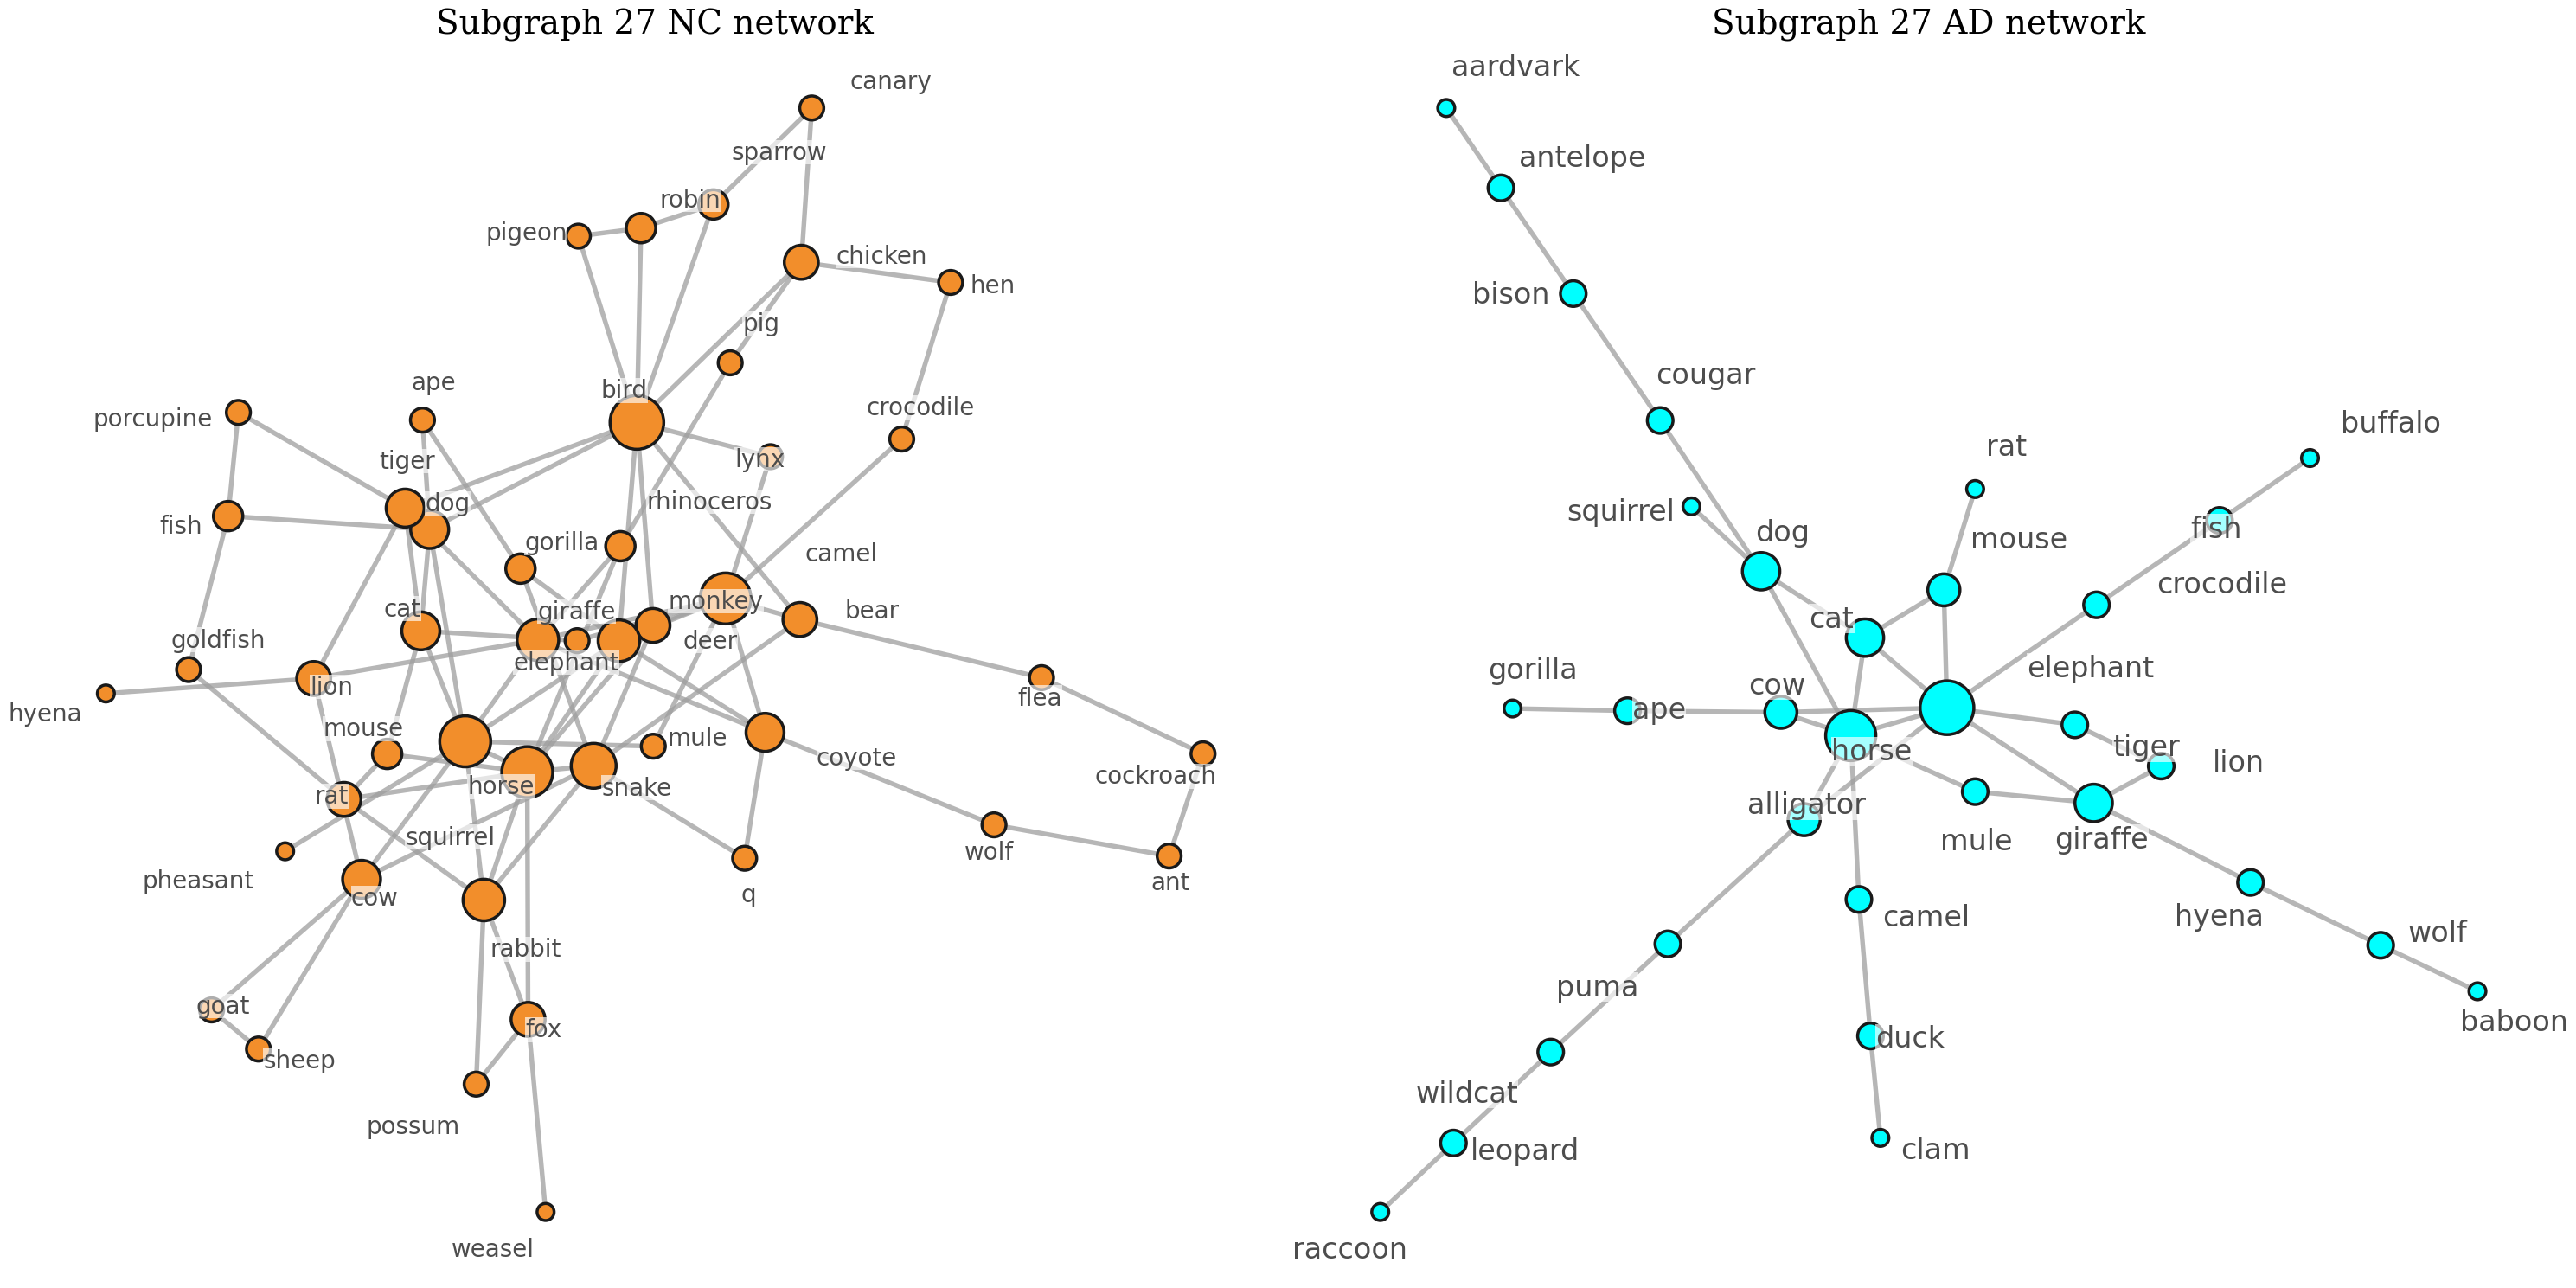

: 

: 

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(30, 15))

# --- Styling to match the example figure ---
node_fill = "#f28e2b"          # orange fill
node_edge = "#1a1a1a"          # dark border
edge_col  = "#9e9e9e"          # gray edges
edge_w    = 3.9
node_lw   = 2.5
label_col = "#4d4d4d"

min_node_size = 200            # prevents tiny dots
max_node_size = 2000           # prevents huge nodes

graph_nc = adj_to_graph(nc_subgraphs[subgraph_i])
nc_items_labels = nc_items[subgraph_i]

graph_ad = adj_to_graph(ad_subgraphs[subgraph_i])
ad_items_labels = ad_items[subgraph_i]

def scaled_node_sizes(G, strength, smin=min_node_size, smax=max_node_size):
    degs = dict(G.degree())
    raw = {n: degs[n] * strength for n in G.nodes()}
    rmin, rmax = (min(raw.values()), max(raw.values())) if raw else (0, 1)
    if rmax == rmin:
        return [0.5 * (smin + smax)] * G.number_of_nodes()
    return [smin + (raw[n] - rmin) * (smax - smin) / (rmax - rmin) for n in G.nodes()]

nodes_sizes_nc = scaled_node_sizes(graph_nc, strenth)
nodes_sizes_ad = scaled_node_sizes(graph_ad, strenth)

def offset_labels(pos, dx=0.02, dy=0.02):
    return {n: (x + dx, y + dy) for n, (x, y) in pos.items()}


# Plot Normal Control Graph
pos_nc = nx.spring_layout(graph_nc, seed=21, k=0.1, iterations=200, scale=3.0)
nx.draw_networkx_edges(graph_nc, pos_nc, edge_color=edge_col, width=edge_w, alpha=0.75, ax=axes[0])
nx.draw_networkx_nodes(
    graph_nc, pos_nc,
    node_size=nodes_sizes_nc,
    node_color=node_fill,
    edgecolors=node_edge,
    linewidths=node_lw,
    ax=axes[0]
)
# --- Labels slightly outside the nodes ---
pos_nc_labels = offset_labels(pos_nc, dx=0.13, dy=0.13)
draw_labels_radial_no_overlap(
    axes[0], graph_nc, pos_nc, nc_items_labels, nodes_sizes_nc,
    fontsize=20, fontcolor=label_col, base_offset=0.09
)
axes[0].set_title(f"Subgraph {subgraph_i} NC network", fontsize=28, fontfamily="serif")
axes[0].axis("off")

# Plot Alzheimer's Disease Graph
pos_ad = nx.spring_layout(graph_ad, seed=42, k=0.1, iterations=200, scale=3.0 )
nx.draw_networkx_edges(graph_ad, pos_ad, edge_color=edge_col, width=edge_w, alpha=0.75, ax=axes[1])
nx.draw_networkx_nodes(
    graph_ad, pos_ad,
    node_size=nodes_sizes_ad,
    node_color="#00FFFF",
    edgecolors=node_edge,
    linewidths=node_lw,
    ax=axes[1]
)
pos_ad_labels = offset_labels(pos_ad, dx=0.13, dy=0.12)
draw_labels_radial_no_overlap(
    axes[1], graph_ad, pos_ad, ad_items_labels, nodes_sizes_ad,
    fontsize=24, fontcolor=label_col, base_offset=0.10
)
axes[1].set_title(f"Subgraph {subgraph_i} AD network", fontsize=28, fontfamily="serif")
axes[1].axis("off")

axes[0].margins(0.01)
axes[1].margins(0.01)

plt.tight_layout()
plt.show()

### 2.1 Louvain algorithm

---Louvain---
Communities: 7
Modularity: 0.5239
Average community size: 4.5714 +/- 1.1780


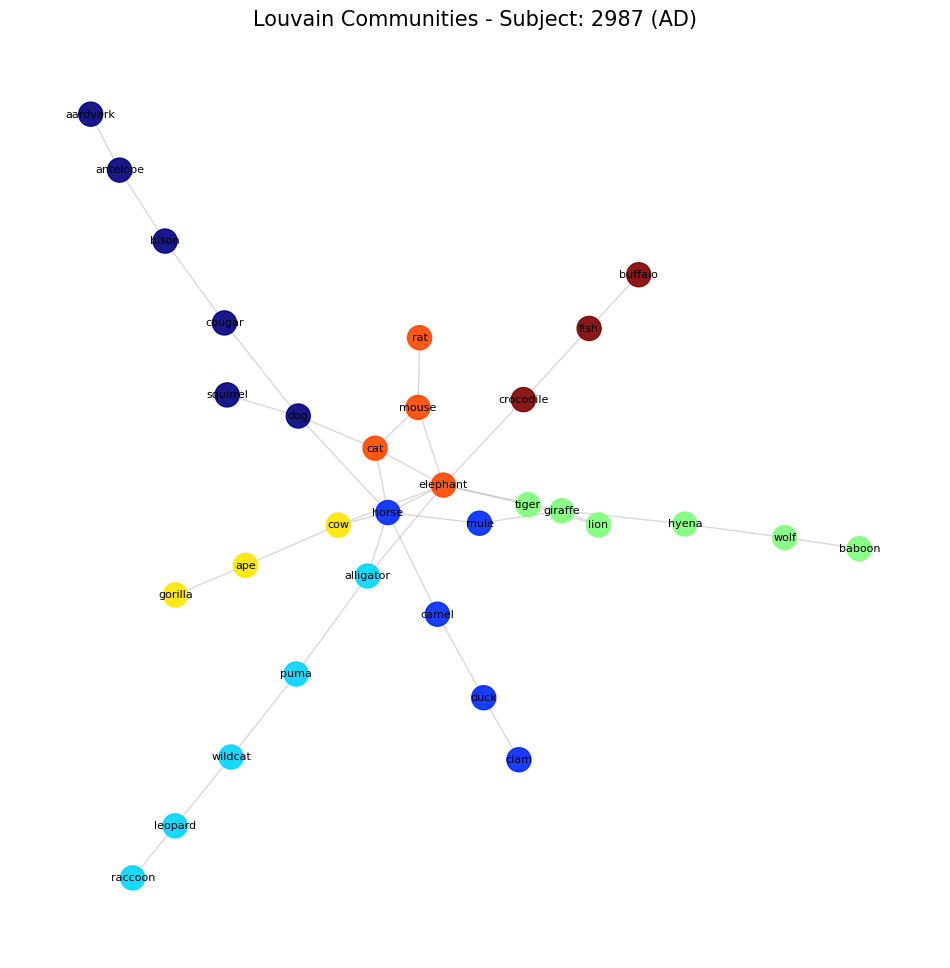

: 

: 

In [ ]:
GROUP_TO_VIEW = 'AD'
SUBJECT_INDEX = 27

file_name = group_files[GROUP_TO_VIEW]
path = os.path.join(folder_path, f"{file_name}.pickle")
data = load_pickle_content(path)

adj_matrix = data['subgraphs'][SUBJECT_INDEX]
subj_id = data['subs'][SUBJECT_INDEX]
item_names =data['items'][SUBJECT_INDEX]

B = binarize_adj(adj_matrix)
G_viz = adj_to_graph(B)

partition = nx.community.louvain_communities(G_viz)
# Modularity
modularity = nx.community.modularity(G_viz, partition)
# Sizes of each community
sizes = [len(c) for c in partition]

print("---Louvain---")
print(f"Communities: {len(partition)}")
print(f"Modularity: {modularity:.4f}")
print(f"Average community size: {np.mean(sizes):.4f} +/- {np.std(sizes):.4f}")

# position
plt.figure(figsize=(12,12))
pos = nx.spring_layout(G_viz, seed=42)

# color
community_map = {}
for i, community in enumerate(partition):
    for node in community:
        community_map[node] = i
node_colors = [community_map[node] for node in G_viz.nodes()]

nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, cmap=plt.cm.jet, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G_viz, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G_viz, pos, labels=item_names, font_size=8, font_color='black')
plt.title(f"Louvain Communities - Subject: {subj_id} ({GROUP_TO_VIEW})", fontsize=15)
plt.axis('off')
plt.show()

### 2.2 DCSBM algorithm

In [ ]:
def nx_to_gt(nx_graph):
    """
    Auxiliary function to convert NetworkX graph to Graph-Tool.
    Necessary because DCSBM runs on graph-tool.
    """
    g = gt.Graph(directed=nx_graph.is_directed()) ## Create empty Graph-tool graph

    # Create node mapping to ensure correspondence
    node_map = {node: g.add_vertex() for node in nx_graph.nodes()}
    # Add edges
    for src, dst in nx_graph.edges():
        g.add_edge(node_map[src], node_map[dst])
    return g, node_map

: 

: 

In [ ]:
def dcsbm_algorithm(G):
    g_gt, vmap = nx_to_gt(G)
    # Run community detection in Graph-tool
    state = gt.minimize_blockmodel_dl(g_gt, state_args=dict(deg_corr=True)) # Minimize description length to find communities
    blocks = state.get_blocks() # Ge the block (community) assignment for each vertex

    # Map results back to original NetworkX nodes
    inv_vmap = {int(v): n for n, v in vmap.items()}  # reverse mapping
    dcbsm_partition = {inv_vmap[int(v)]: int(blocks[v]) for v in g_gt.vertices()} # Map each NetworkX node to its community
    return dcbsm_partition, state

: 

: 

---DCSBM---
Communities: 1
Modularity: 0.0000
Average community size: 32.0000 +/- 0.0000


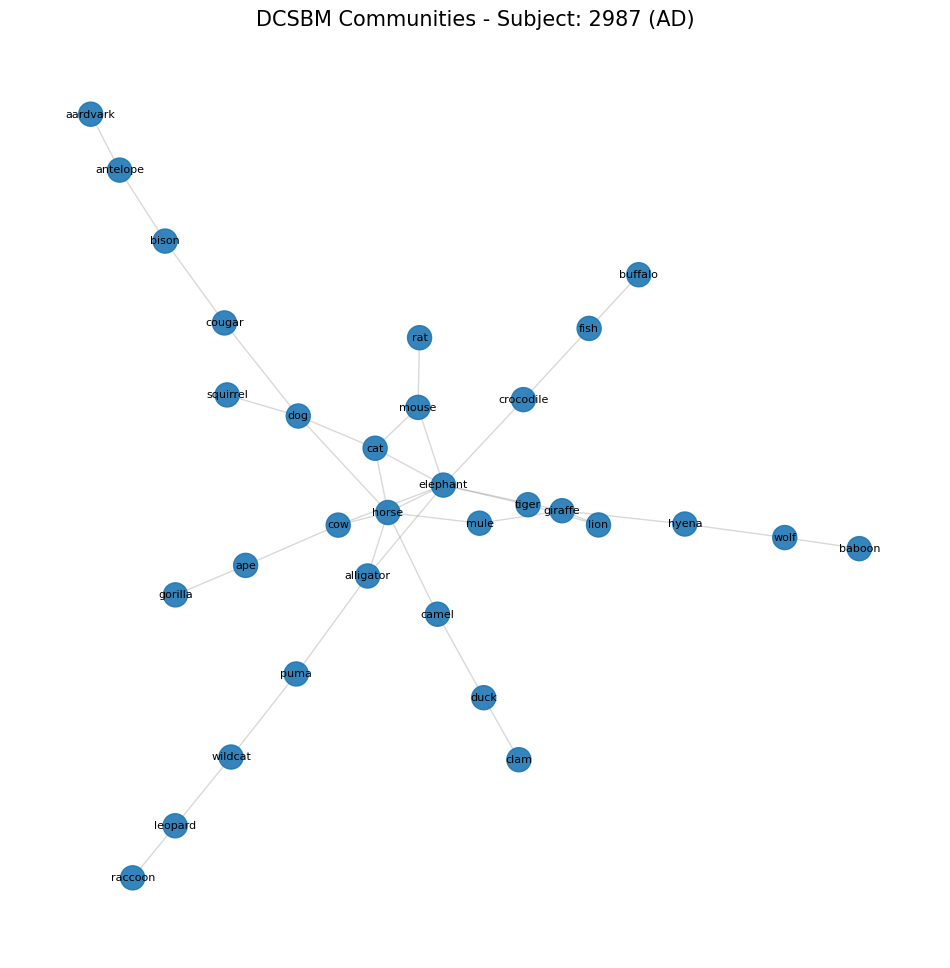

: 

: 

In [ ]:
GROUP_TO_VIEW = 'AD'
SUBJECT_INDEX = 27

file_name = group_files[GROUP_TO_VIEW]
path = os.path.join(folder_path, f"{file_name}.pickle")
data = load_pickle_content(path)

adj_matrix = data['subgraphs'][SUBJECT_INDEX]
subj_id = data['subs'][SUBJECT_INDEX]
item_names =data['items'][SUBJECT_INDEX]

B = binarize_adj(adj_matrix)
G_viz = adj_to_graph(B)

partition, _ = dcsbm_algorithm(G_viz)

num_communities = len(set(partition.values()))

#Modularity
groups = {}
for node, comm_id in partition.items():
    groups.setdefault(comm_id, set()).add(node)
modularity = nx.community.modularity(G_viz, list(groups.values()))

# Sizes of each community
sizes = [len(c) for c in groups.values()]

print("---DCSBM---")
print(f"Communities: {len(groups)}")
print(f"Modularity: {modularity:.4f}")
print(f"Average community size: {np.mean(sizes):.4f} +/- {np.std(sizes):.4f}")

plt.figure(figsize=(12,12))
#position
pos = nx.spring_layout(G_viz, seed=42)
#color
node_colors = [partition[node] for node in G_viz.nodes()]

nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G_viz, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G_viz, pos, labels=item_names, font_size=8, font_color='black')
plt.title(f"DCSBM Communities - Subject: {subj_id} ({GROUP_TO_VIEW})", fontsize=15)
plt.axis('off')
plt.show()

### 2.3 Infomap algorithm

In [ ]:
def infomap_algorithm(G):
    im = Infomap(silent=True, directed=G.is_directed()) # Create empty Infomap graph
    nodes_list = list(G.nodes())
    vmap = {node: i for i, node in enumerate(G.nodes())} ## Add a vertex to Infomap graph and store the mapping
    for u, v in G.edges(): # For each edge in NetworkX graph
        im.add_link(int(vmap[u]), int(vmap[v])) ## Add corresponding edge in Infomap graph
    im.run() # Run Infomap

    inv_map ={i: node for node, i in vmap.items()} # Inverse mapping from Infomap vertices to original NetworkX nodes
    infomap_partition = {} # We assign the community to each node
    for node in im.tree:
        if node.is_leaf:
            original_id = inv_map[node.node_id]
            infomap_partition[original_id] = node.module_id

    if infomap_partition:
        next_module_id = max(infomap_partition.values()) + 1
    else:
        next_module_id = 1

    # Assign unic community to the isolated nodes
    for node in nodes_list:
        if node not in infomap_partition:
            infomap_partition[node] = next_module_id
            next_module_id += 1

    community_node_infomap={node: comm_id-1 for node, comm_id in infomap_partition.items()}

    return community_node_infomap, im

: 

: 

### 2.3 Infomap algorithm

In [ ]:
def infomap_algorithm(G):
    im = Infomap(silent=True, directed=G.is_directed()) # Create empty Infomap graph
    nodes_list = list(G.nodes())
    vmap = {node: i for i, node in enumerate(G.nodes())} ## Add a vertex to Infomap graph and store the mapping
    for u, v in G.edges(): # For each edge in NetworkX graph
        im.add_link(int(vmap[u]), int(vmap[v])) ## Add corresponding edge in Infomap graph
    im.run() # Run Infomap

    inv_map ={i: node for node, i in vmap.items()} # Inverse mapping from Infomap vertices to original NetworkX nodes
    infomap_partition = {} # We assign the community to each node
    for node in im.tree:
        if node.is_leaf:
            original_id = inv_map[node.node_id]
            infomap_partition[original_id] = node.module_id

    if infomap_partition:
        next_module_id = max(infomap_partition.values()) + 1
    else:
        next_module_id = 1

    # Assign unic community to the isolated nodes
    for node in nodes_list:
        if node not in infomap_partition:
            infomap_partition[node] = next_module_id
            next_module_id += 1

    community_node_infomap={node: comm_id-1 for node, comm_id in infomap_partition.items()}

    return community_node_infomap, im

: 

: 

---Infomap---
Communities: 7
Modularity: 0.5045
Average community size: 4.5714 +/- 2.8714


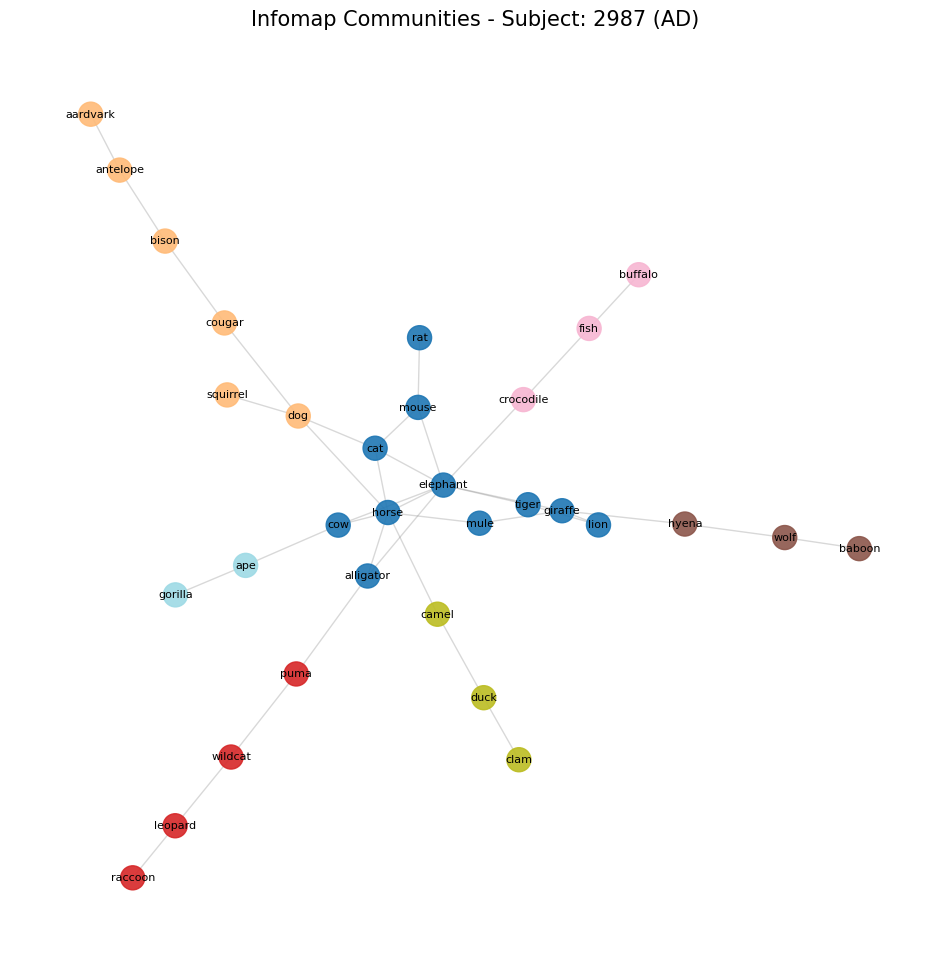

: 

: 

In [ ]:
GROUP_TO_VIEW = 'AD'
SUBJECT_INDEX = 27

file_name = group_files[GROUP_TO_VIEW]
path = os.path.join(folder_path, f"{file_name}.pickle")
data = load_pickle_content(path)

adj_matrix = data['subgraphs'][SUBJECT_INDEX]
subj_id = data['subs'][SUBJECT_INDEX]
item_names =data['items'][SUBJECT_INDEX]

B = binarize_adj(adj_matrix)
G_viz = adj_to_graph(B)

partition, _ = infomap_algorithm(G_viz)

#Modularity
groups = {}
for node, comm_id in partition.items():
    groups.setdefault(comm_id, set()).add(node)
modularity = nx.community.modularity(G_viz, list(groups.values()))

# Sizes of each community
sizes = [len(c) for c in groups.values()]

print("---Infomap---")
print(f"Communities: {len(groups)}")
print(f"Modularity: {modularity:.4f}")
print(f"Average community size: {np.mean(sizes):.4f} +/- {np.std(sizes):.4f}")

plt.figure(figsize=(12,12))
# position
pos = nx.spring_layout(G_viz, seed=42)
# color
node_colors = [partition[node] for node in G_viz.nodes()]

nx.draw_networkx_nodes(G_viz, pos, node_color=node_colors, cmap=plt.cm.tab20, node_size=300, alpha=0.9)
nx.draw_networkx_edges(G_viz, pos, alpha=0.3, edge_color='gray')
nx.draw_networkx_labels(G_viz, pos, labels=item_names, font_size=8, font_color='black')
plt.title(f"Infomap Communities - Subject: {subj_id} ({GROUP_TO_VIEW})", fontsize=15)
plt.axis('off')
plt.show()

### 2.4 Computing community anlyses for all Real Networks

In [ ]:
def analyze_communities(adj_matrix, threshold=0.0):
    """
    Calculate community metrics for an adjacency matrix using:
    1. Louvain (Modularity Q)
    2. DCSBM (Minimum Description Length - DL)
    3. Infomap (Number of modules)

    Community metrics:
    - Number of communities
    - Modularity
    - Average community size
    """
    metrics = {}

    keys = [
        'louvain_num', 'louvain_Q', 'louvain_avg_size',
        'dcsbm_num', 'dcsbm_Q', 'dcsbm_avg_size', 'dcsbm_DL',
        'infomap_num', 'infomap_Q', 'infomap_avg_size', 'infomap_CL'
    ]

    for k in keys:
        metrics[k] = np.nan

    # Preprocessing
    B = binarize_adj(adj_matrix, threshold)
    G_nx = adj_to_graph(B)

    # Skip empty graphs
    if G_nx.number_of_edges() == 0:
        return metrics

    # --- 1. LOUVAIN ---
    try:
        communities_list = nx.community.louvain_communities(G_nx)
        sizes = [len(c) for c in communities_list]

        metrics['louvain_num'] = len(communities_list)
        metrics['louvain_Q'] = nx.community.modularity(G_nx, communities_list)
        metrics['louvain_avg_size'] = np.mean(sizes)
    except:
        print(f"Louvain Error: {e}")

    # --- 2. DCSBM (Degree-Corrected Stochastic Block Model) ---
    try:
        partition_dict, sate_obj = dcsbm_algorithm(G_nx)

        # Modularty
        groups = {}
        for node, comm_id in partition_dict.items():
            groups.setdefault(comm_id, set()).add(node)
        modularity = nx.community.modularity(G_nx, list(groups.values()))

        # Sizes of each community
        sizes = [len(c) for c in groups.values()]

        metrics['dcsbm_num'] = len(groups)
        metrics['dcsbm_Q'] = modularity
        metrics['dcsbm_avg_size'] = np.mean(sizes)
        metrics['dcsbm_DL'] = sate_obj.entropy() # Lower entropy (DL) = Stronger / more predictable structure.

    except Exception as e:
        print(f"DCSBM Error: {e}")


    # --- 3. INFOMAP ---
    try:
        partition_dict, im_obj = infomap_algorithm(G_nx)
        # modularity
        groups = {}
        for node, comm_id in partition_dict.items():
            groups.setdefault(comm_id, set()).add(node)
        modularity = nx.community.modularity(G_nx, list(groups.values()))

        # Sizes
        sizes = [len(c) for c in groups.values()]

        metrics['infomap_num'] = len(groups)
        metrics['infomap_Q'] = modularity
        metrics['infomap_avg_size'] = np.mean(sizes)
        metrics['infomap_CL'] = im_obj.codelength
    except:
        print(f"Infomap Error: {e}")

    return metrics

: 

: 

In [ ]:
print("Analysing communities...")
folder_path = "../Datasets/Networks/"
community_results = []

for group_name, file_name in group_files.items():
    print(f"Processing {group_name} group...")

    # 1. Charge Real Data
    original_path = os.path.join(folder_path, f"{file_name}.pickle")
    if not os.path.exists(original_path):
        print(f"ERROR: Original file not found: {original_path}")
        continue

    data_orig = load_pickle_content(original_path) # Usando tu función
    print(f"Loaded {len(data_orig['subs'])} subjects from the original file.")


    # Initialize results dictionary
    subjects_results = {}
    # Calculate metrics for REAL graphs
    for subj_id, adjacency_matrix in zip(data_orig['subs'], data_orig['subgraphs']):
        metrics = analyze_communities(adjacency_matrix)
        subjects_results[subj_id] = {
            'real': metrics,
            'shuf_accum': []
        }


    # --- B. Process Shuffled Graphs (Baseline) ---
    shuffled_files_list = [
        f for f in files
        if f.startswith(file_name) and "shuffled" in f and f.endswith(".pickle")
    ]

    # Sort them to process in order
    shuffled_files_list.sort()

    n_shuffles_found = len(shuffled_files_list)
    print(f"Found {n_shuffles_found} shuffled files for group {group_name}.")
    if n_shuffles_found == 0:
        print("WARNING: No shuffled files found. Skipping Small World calculation.")

    for idx, shuf_filename in enumerate(shuffled_files_list):
        shuf_path = os.path.join(folder_path, shuf_filename)

        print(f"Reading shuffled file {idx + 1}/{n_shuffles_found}: {shuf_filename}")
        try:
            data_shuf = load_pickle_content(shuf_path)
            graphs_map = dict(zip(data_shuf['subs'], data_shuf['subgraphs']))

            # Match shuffled networks to their subjects
            for subj_id in subjects_results.keys():
                if subj_id in graphs_map:
                    adjacency_matrix = graphs_map[subj_id]
                    m_shuf = analyze_communities(adjacency_matrix)
                    subjects_results[subj_id]['shuf_accum'].append(m_shuf)

        except Exception as e:
            print(f"  Error leyendo {shuf_filename}: {e}")

    # --- C. Average Shuffled and save in DataFrame ---
    for subj_id, content in subjects_results.items():
        real_metrics = content['real']
        shuf_list = content['shuf_accum']

        # Check if we have data to average
        if len(shuf_list) == 0:
            small_world = np.nan
            shuf_means = {k: np.nan for k in real_metrics.keys()} # Empty dict with NaNs
        else:
            # Convert list of dicts to DataFrame to compute the mean
            # Pandas automatically handles the division by N (however many files were found)
            df_shuf = pd.DataFrame(shuf_list)
            shuf_means = df_shuf.mean().to_dict()


        # Construct the final row
        row = {
            'subject': subj_id,
            'group': group_name,
            **real_metrics,
            **{f'shuf_{k}': v for k, v in shuf_means.items()}
        }
        community_results.append(row)

# Create Final DataFrame
df_communities = pd.DataFrame(community_results)

# Compute Deltas (Real - Random)
# A Q higher than chance indicates a strong structure.
df_communities['delta_louvain_Q'] = df_communities['louvain_Q'] - df_communities['shuf_louvain_Q']
df_communities['delta_dcsbm_Q'] = df_communities['dcsbm_Q'] - df_communities['shuf_dcsbm_Q']
df_communities['delta_infomap_Q'] = df_communities['infomap_Q'] - df_communities['shuf_infomap_Q']

# In DCSBM, we want to see if the real network is more orderly (lower antropy DL) than the random one.
df_communities['delta_dcsbm_DL'] = df_communities['dcsbm_DL'] - df_communities['shuf_dcsbm_DL']

# In Infomap, codelength (CL) measures verbal fluency in a barrage of words.
df_communities['delta_infomap_CL'] = df_communities['infomap_CL'] - df_communities['shuf_infomap_CL']

# Save
df_communities.to_csv('../Results/Tables/community_metrics.csv', index=False)
print("Done! Results saved.")
df_communities.head()

Analysing communities...
Processing AD group...
Loaded 61 subjects from the original file.
Found 50 shuffled files for group AD.
Reading shuffled file 1/50: ucsd_ad_graphs_usf_persev_shuffled_0.pickle
Reading shuffled file 2/50: ucsd_ad_graphs_usf_persev_shuffled_1.pickle
Reading shuffled file 3/50: ucsd_ad_graphs_usf_persev_shuffled_10.pickle
Reading shuffled file 4/50: ucsd_ad_graphs_usf_persev_shuffled_11.pickle
Reading shuffled file 5/50: ucsd_ad_graphs_usf_persev_shuffled_12.pickle
Reading shuffled file 6/50: ucsd_ad_graphs_usf_persev_shuffled_13.pickle
Reading shuffled file 7/50: ucsd_ad_graphs_usf_persev_shuffled_14.pickle
Reading shuffled file 8/50: ucsd_ad_graphs_usf_persev_shuffled_15.pickle
Reading shuffled file 9/50: ucsd_ad_graphs_usf_persev_shuffled_16.pickle
Reading shuffled file 10/50: ucsd_ad_graphs_usf_persev_shuffled_17.pickle
Reading shuffled file 11/50: ucsd_ad_graphs_usf_persev_shuffled_18.pickle
Reading shuffled file 12/50: ucsd_ad_graphs_usf_persev_shuffled_19.p

,subject,group,louvain_num,louvain_Q,louvain_avg_size,dcsbm_num,dcsbm_Q,dcsbm_avg_size,dcsbm_DL,infomap_num,...,shuf_dcsbm_DL,shuf_infomap_num,shuf_infomap_Q,shuf_infomap_avg_size,shuf_infomap_CL,delta_louvain_Q,delta_dcsbm_Q,delta_infomap_Q,delta_dcsbm_DL,delta_infomap_CL
0,14003,AD,4,0.438776,3.250000,1,1.110223e-16,13.0,41.806538,4,...,44.994146,2.90,0.332739,5.135000,3.191029,0.051863,8.659740e-17,0.113690,-3.187608,-0.058547
1,14021,AD,4,0.328750,3.500000,1,0.000000e+00,14.0,54.808249,1,...,54.083394,2.24,0.190714,8.096667,3.465555,0.005868,0.000000e+00,-0.190714,0.724856,0.181530
2,2017,AD,5,0.542969,3.400000,1,0.000000e+00,17.0,49.954557,4,...,55.898893,3.98,0.532004,4.369000,3.181170,0.013929,0.000000e+00,0.010965,-5.944336,-0.072297
3,2087,AD,7,0.538227,7.142857,1,1.110223e-16,50.0,271.346510,7,...,325.715137,7.18,0.317844,7.236905,4.870752,0.160035,9.325873e-17,0.205681,-54.368628,-0.457426
4,2095,AD,5,0.390370,5.000000,1,0.000000e+00,25.0,137.609439,5,...,135.726305,3.74,0.334936,7.683333,4.155822,-0.004986,-8.881784e-18,0.040620,1.883134,-0.023621


: 

: 

## 3. Subject Similarity Network

1. Load and unify data

In [ ]:
df_comm = pd.read_csv('../Results/Tables/community_metrics.csv')
df_glob = pd.read_csv('../Results/Tables/global_network_metrics.csv')
df_master = pd.merge(df_comm, df_glob, on=['subject', 'group'])

df_master['unique_id'] = df_master['subject'].astype(str) + "_" + df_master['group']
subjects = df_master['unique_id'].astype(str).values
groups = df_master['group'].values

print(f"Total of subjects: {len(np.unique(subjects))}")
print(f"Total of unique subjects: {len(np.unique(df_master['subject']))}")
print(f"Subjects with doble entries (AD and NC): {len(df_master) - len(np.unique(df_master['subject']))}")

Total of subjects: 158
Total of unique subjects: 139
Subjects with doble entries (AD and NC): 19


: 

: 

2. Features selection

Select only the ones that are statistically significant when comparing Real vs Shuffled networks.  
Then, of those selected features, filter only the ones that are statistically signficiant when comparing NC vs AD (p<0.001).

In [ ]:
selected_features = [
    # -- Global --
    'num_nodes',        # (***)
    'avg_degree',       # (***)
    'clustering',       # (***)
    'diameter',         # (***)
    'density',          # (***)
    'spl',              # (***)

    # -- Community --
    'louvain_num',      # (***)
    'louvain_Q',        # (***)
    'louvain_avg_size', # (***)
    'dcsbm_DL',         # (***)
    'infomap_num',      # (***)
    'infomap_Q',        # (***)
    'infomap_CL'        # (***)
]

features = [f for f in selected_features if f in df_master.columns]
print(f"Using {len(features)} significative metrics: {features}")

Using 13 significative metrics: ['num_nodes', 'avg_degree', 'clustering', 'diameter', 'density', 'spl', 'louvain_num', 'louvain_Q', 'louvain_avg_size', 'dcsbm_DL', 'infomap_num', 'infomap_Q', 'infomap_CL']


: 

: 

3. Feature normalization

This is done so that 'num_nodes' (rango 0-100) does not dominate 'louvain_Q' (rango 0-1)

In [ ]:
X = df_master[features].values
X = np.nan_to_num(X) # If NaNs, convert to 0
X_scaled = StandardScaler().fit_transform(X) # Normalize

: 

: 

4. True partition

In [ ]:
y_true = np.where(df_master['group'] == 'AD', 1, 0) # AD=1, NC=0
part_true = dict(zip(subjects, y_true))

: 

: 

5.  SSN Network construction

In [ ]:
# Compute similarity matrix (Inverse from Euclidian distance)
dist_matrix = squareform(pdist(X_scaled, metric='euclidean'))
similarity_matrix = 1 / (1 + dist_matrix)

# Create Graph k-NN
K = 5 # Connect each subject to K nearest neighbors
SSN = nx.Graph()

for i in range(len(subjects)):
    SSN.add_node(subjects[i], group=groups[i])

    # Índex from nearest K neighbors (excluding self)
    nearest_index = np.argsort(dist_matrix[i])[1:K+1]

    for neighbor_idx in nearest_index:
        weight = similarity_matrix[i, neighbor_idx]
        SSN.add_edge(subjects[i], subjects[neighbor_idx], weight=weight)

: 

: 

6. Visualization

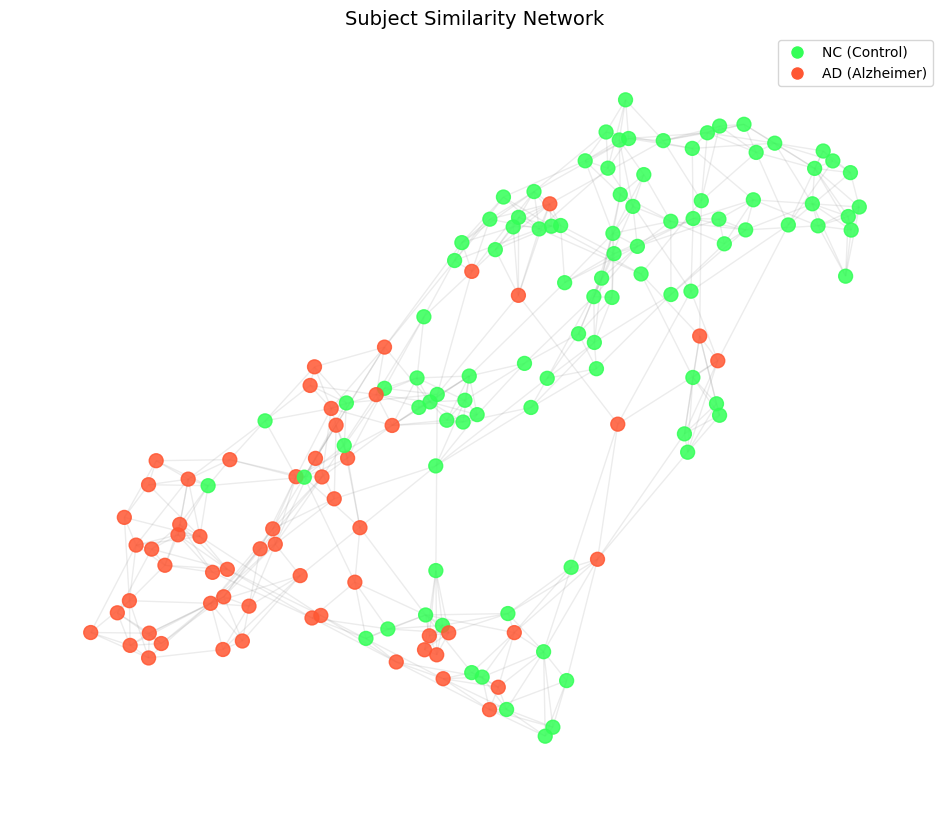

: 

: 

In [ ]:
plt.figure(figsize=(12, 10))

# Layout
pos = nx.spring_layout(SSN, seed=42)

# Colors
color_map = {'AD': '#FF5733', 'NC': '#33FF57'} # Rojo/Verde o lo que prefieras
node_colors = [color_map[SSN.nodes[n]['group']] for n in SSN.nodes()]

# Draw
nx.draw_networkx_nodes(SSN, pos, node_size=100, node_color=node_colors, alpha=0.85)
nx.draw_networkx_edges(SSN, pos, alpha=0.15, edge_color='gray')

# Legend
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#33FF57', label='NC (Control)', markersize=10),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF5733', label='AD (Alzheimer)', markersize=10)
]
plt.legend(handles=legend_elements, loc='upper right')

plt.title(f"Subject Similarity Network", fontsize=14)
plt.axis('off')
plt.show()

### 3.1 Community analysis

In [ ]:
def evaluate_method(partition_dict, method_name):
    """
    Evaluate how well the detected partition matches the actual groups (AD/NC).
    """
    # Prediction vector aligned with y_true
    preds_raw = np.array([partition_dict.get(subj, -1) for subj in subjects])

    # Mapping clusters to labels (0=NC, 1=AD)
    unique_clusters = np.unique(preds_raw)
    preds_mapped = np.zeros_like(preds_raw)
    cluster_mapping_str = []

    for cluster_id in unique_clusters:
        if cluster_id == -1: continue # Node without community (rare)

        # Subject indices in this cluster
        indices = np.where(preds_raw == cluster_id)[0]
        true_labels = y_true[indices]

        # Majority vote
        n_ad = np.sum(true_labels == 1)
        n_nc = np.sum(true_labels == 0)

        assigned_label = 1 if n_ad >= n_nc else 0
        preds_mapped[indices] = assigned_label

        label_str = "AD" if assigned_label == 1 else "NC"
        purity = max(n_ad, n_nc) / len(indices)
        cluster_mapping_str.append(f"C{cluster_id}->{label_str} ({purity:.0%} purity)")

    # Metrics
    acc = accuracy_score(y_true, preds_mapped)
    ari = adjusted_rand_score(y_true, preds_raw)
    cm = confusion_matrix(y_true, preds_mapped)

    print(f"\n--- {method_name} ---")
    print(f"Detected communities: {len(unique_clusters)}")
    print(f"Mapping: {', '.join(cluster_mapping_str)}")
    print(f"Accuracy: {acc:.2%}")
    print(f"Adjusted Rand Index: {ari:.3f}")
    print("Confusion matrix:")
    print(f"      Pred NC (0)   Pred AD (1)")
    print(f"Real NC    {cm[0,0]}           {cm[0,1]}")
    print(f"Real AD    {cm[1,0]}           {cm[1,1]}")

    return acc

: 

: 

In [ ]:
evaluate_method(part_true, "Ground Truth (Reference)")


--- Ground Truth (Reference) ---
Detected communities: 2
Mapping: C0->NC (100% purity), C1->AD (100% purity)
Accuracy: 100.00%
Adjusted Rand Index: 1.000
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    97           0
Real AD    0           61


1.0

: 

: 

#### Louvain

In [ ]:
louvain_comms = nx.community.louvain_communities(SSN, weight='weight') # Weighted
part_louvain = {}
for i, comm in enumerate(louvain_comms):
    for node in comm: part_louvain[node] = i
evaluate_method(part_louvain, "LOUVAIN")


--- LOUVAIN ---
Detected communities: 9
Mapping: C0->AD (93% purity), C1->AD (95% purity), C2->AD (50% purity), C3->NC (75% purity), C4->NC (52% purity), C5->NC (73% purity), C6->NC (100% purity), C7->NC (83% purity), C8->NC (100% purity)
Accuracy: 81.01%
Adjusted Rand Index: 0.113
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    89           8
Real AD    22           39


0.810126582278481

: 

: 

#### DCSBM

In [ ]:
part_dcsbm, _ = dcsbm_algorithm(SSN)
evaluate_method(part_dcsbm, "DCSBM")


--- DCSBM ---
Detected communities: 7
Mapping: C2->AD (93% purity), C13->NC (52% purity), C35->NC (53% purity), C39->AD (100% purity), C61->NC (75% purity), C121->NC (100% purity), C147->NC (100% purity)
Accuracy: 78.48%
Adjusted Rand Index: 0.105
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    96           1
Real AD    33           28


0.7848101265822784

: 

: 

#### Infomap

In [ ]:
part_infomap, _ = infomap_algorithm(SSN)
evaluate_method(part_infomap, "INFOMAP")


--- INFOMAP ---
Detected communities: 2
Mapping: C0->AD (64% purity), C1->NC (93% purity)
Accuracy: 77.22%
Adjusted Rand Index: 0.292
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    66           31
Real AD    5           56


0.7721518987341772

: 

: 

### 3.2 Community Analysis forcing 2 Blocks

#### Spectral Clustering

This method cuts the graph using eigenvalues.  
It is the standard way to “force” cuts in similarity graphs.

In [ ]:
sc = SpectralClustering(n_clusters=2, affinity='precomputed', random_state=42)
spectral_labels = sc.fit_predict(similarity_matrix)

part_spectral = {subjects[i]: spectral_labels[i] for i in range(len(subjects))}
evaluate_method(part_spectral, "Spectral Clustering")


--- Spectral Clustering ---
Detected communities: 2
Mapping: C0->AD (66% purity), C1->NC (89% purity)
Accuracy: 77.22%
Adjusted Rand Index: 0.292
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    70           27
Real AD    9           52


0.7721518987341772

: 

: 

#### Agglomerative Clustering

This method joins the most similar nodes until there are two groups left.  
It is very robust for detecting structure.

In [ ]:

ac = AgglomerativeClustering(n_clusters=2, metric='precomputed', linkage='complete')

# Agglomerative expects distance, no similarity. We use dist_matrix.
agglom_labels = ac.fit_predict(dist_matrix)

part_agglom = {subjects[i]: agglom_labels[i] for i in range(len(subjects))}
evaluate_method(part_agglom, "Agglomerative Clustering")


--- Agglomerative Clustering ---
Detected communities: 2
Mapping: C0->NC (76% purity), C1->AD (94% purity)
Accuracy: 79.75%
Adjusted Rand Index: 0.340
Confusion matrix:
      Pred NC (0)   Pred AD (1)
Real NC    95           2
Real AD    30           31


0.7974683544303798

: 

: 

## 4. New approach for organizing this dataset

### 4.1 Definition of Networks

In [ ]:
# CORE FUNCTIONS

def flatten_fluency_items(data):
    """
    Flatten all fluency items in a dataset into a single list.

    Each element in data['items'] can be:
        - A single list/dict
        - A list of lists/dicts
    """
    flattened = []

    for subj_items in data['items']:
        if isinstance(subj_items, list):
            # Check if it's a list of lists or list of dicts
            if len(subj_items) == 0:
                continue  # skip empty lists
            if isinstance(subj_items[0], (list, dict)):
                flattened.extend(subj_items)
            else:
                # single-level list
                flattened.append(subj_items)
        elif isinstance(subj_items, dict):
            flattened.append(subj_items)
        else:
            print("Warning: unexpected type:", type(subj_items))

    return flattened

def fluency_list_to_transition_graph(fluency_list, remove_self_loops=True):
    """
    Converts a fluency list (or dict with trials) to a directed transition graph.
    Works safely if input is a dict, list of lists, or single list.
    """
    # If dict, extract values
    if isinstance(fluency_list, dict):
        # assume dict has trials or numbered keys
        trials = list(fluency_list.values())
        # flatten if only 1-level list
        fluency_list = [word for trial in trials for word in (trial if isinstance(trial, list) else [trial])]

    # If numpy array, convert to list
    if not isinstance(fluency_list, list):
        try:
            fluency_list = fluency_list.tolist()
        except AttributeError:
            fluency_list = list(fluency_list)

    # Remove empty strings or None
    fluency_list = [w for w in fluency_list if w]

    G = nx.DiGraph()
    G.add_nodes_from(set(fluency_list))

    # Count transitions
    transitions = Counter(zip(fluency_list[:-1], fluency_list[1:]))

    for (u, v), w in transitions.items():
        if remove_self_loops and u == v:
            continue
        if G.has_edge(u, v):
            G[u][v]['weight'] += w
        else:
            G.add_edge(u, v, weight=w)

    return G

def subject_dict_to_fluency_list(subj_dict):
    """
    subj_dict: {position: word}
    returns: ordered list of words
    """
    if not isinstance(subj_dict, dict):
        return []

    # Sort by position
    ordered_items = sorted(subj_dict.items(), key=lambda x: x[0])

    # Extract words, drop empty / invalid
    fluency_list = [
        word for _, word in ordered_items
        if isinstance(word, str) and word.strip() != ""
    ]

    return fluency_list

# Function to plot a single transition graph
def plot_transition_graph(G, fluency_list, title="Transition Graph"):
    plt.figure(figsize=(10, 5))

    # Count frequency of each word
    word_counts = Counter(fluency_list)

    # Assign node sizes based on frequency (scale factor for visibility)
    node_sizes = [200 + 100 * word_counts.get(node, 1) for node in G.nodes()]

    # Use a spring layout for nicer visualization
    pos = nx.spring_layout(G, seed=42)

    # Draw nodes and edges
    nx.draw_networkx_nodes(G, pos, node_color='orange', node_size=node_sizes)
    nx.draw_networkx_edges(G, pos, arrowstyle='->', arrowsize=12, edge_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=9)
    nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight'] for u,v in G.edges()])


    plt.title(title)
    plt.axis('off')
    plt.show()

: 

: 

In [ ]:
NETWORKS_DIR = "/content/drive/MyDrive/CN/A3 Project/Datasets/Networks/"

NC_REAL_FILE = "ucsd_nc_graphs_usf_persev.pickle"
AD_REAL_FILE = "ucsd_ad_graphs_usf_persev.pickle"

nc_path = os.path.join(NETWORKS_DIR, NC_REAL_FILE)
ad_path = os.path.join(NETWORKS_DIR, AD_REAL_FILE)

nc_data = load_pickle_content(nc_path)
ad_data = load_pickle_content(ad_path)


# Apply function
nc_fluency_lists = flatten_fluency_items(nc_data)
ad_fluency_lists = flatten_fluency_items(ad_data)
nc_fluency_lists2 = flatten_fluency_items(nc_data)
ad_fluency_lists2 = flatten_fluency_items(ad_data)

# Print results
print("Number of fluency lists for AD subjects:", len(ad_fluency_lists))
print("Number of fluency lists for NC subjects:", len(nc_fluency_lists))
print("First AD fluency list example:", ad_fluency_lists[0])
print("First NC fluency list example:", nc_fluency_lists[0])

print("Number of fluency dicts for AD subjects:", len(ad_fluency_lists2))
print("Number of fluency dicts for NC subjects:", len(nc_fluency_lists2))

Number of fluency lists for AD subjects: 61
Number of fluency lists for NC subjects: 97
First AD fluency list example: {0: 'giraffe', 1: 'kangaroo', 2: 'tiger', 3: 'lion', 4: 'alligator', 5: 'dog', 6: 'cat', 7: 'rabbit', 8: 'reptile', 9: 'zebra', 10: 'camel', 11: 'dromedary', 12: 'mouse'}
First NC fluency list example: {0: 'cow', 1: 'sheep', 2: 'dog', 3: 'cat', 4: 'monkey', 5: 'zebra', 6: 'horse', 7: 'tiger', 8: 'alligator', 9: 'buffalo', 10: 'q', 11: 'aardvark', 12: 'fox', 13: 'wolf', 14: 'coyote', 15: 'possum', 16: 'skunk', 17: 'squirrel', 18: 'lion', 19: 'elephant', 20: 'hippopotamus', 21: 'raccoon'}
Number of fluency dicts for AD subjects: 61
Number of fluency dicts for NC subjects: 97


: 

: 

### 4.2 Word-level transition Networks


In [ ]:
# Building the network for all subjects
nc_fluency_lists = [
    subject_dict_to_fluency_list(subj)
    for subj in nc_data["items"]
    if len(subject_dict_to_fluency_list(subj)) >= 2
]

ad_fluency_lists = [
    subject_dict_to_fluency_list(subj)
    for subj in ad_data["items"]
    if len(subject_dict_to_fluency_list(subj)) >= 2
]

nc_transition_graphs = [
    fluency_list_to_transition_graph(lst)
    for lst in nc_fluency_lists
]

ad_transition_graphs = [
    fluency_list_to_transition_graph(lst)
    for lst in ad_fluency_lists
]
print("NC transition graphs:", len(nc_transition_graphs))
print("AD transition graphs:", len(ad_transition_graphs))

NC transition graphs: 97
AD transition graphs: 61


: 

: 

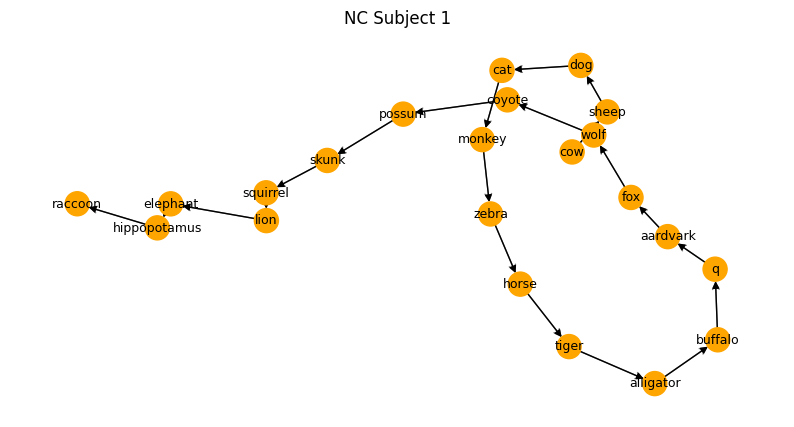

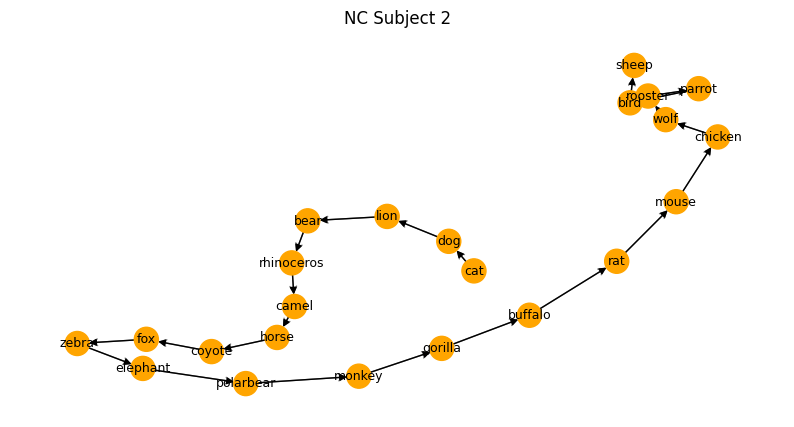

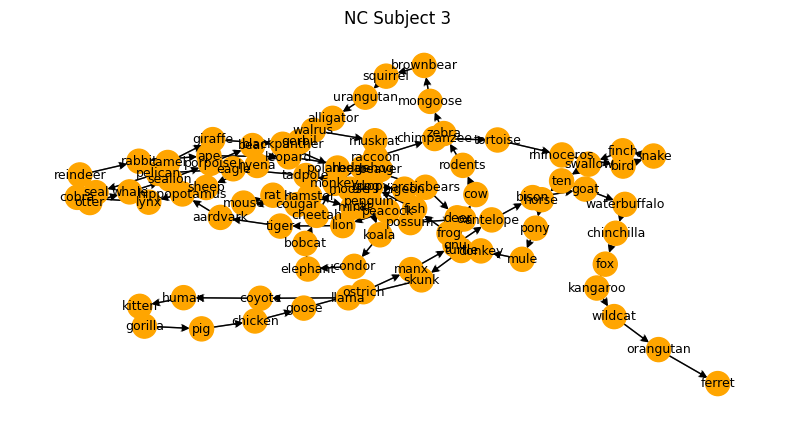

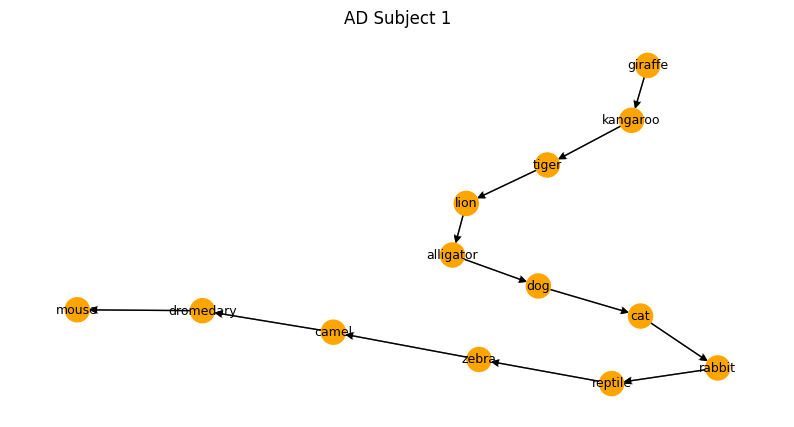

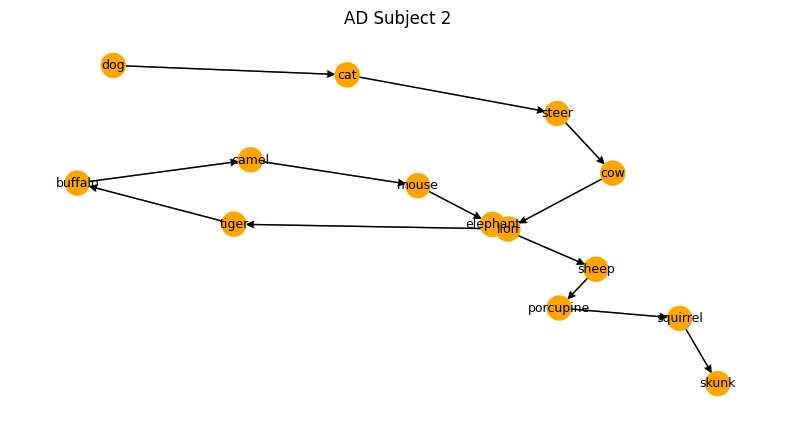

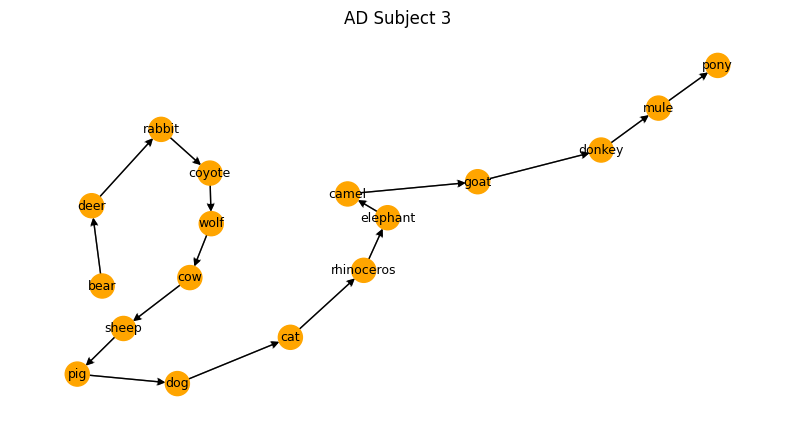

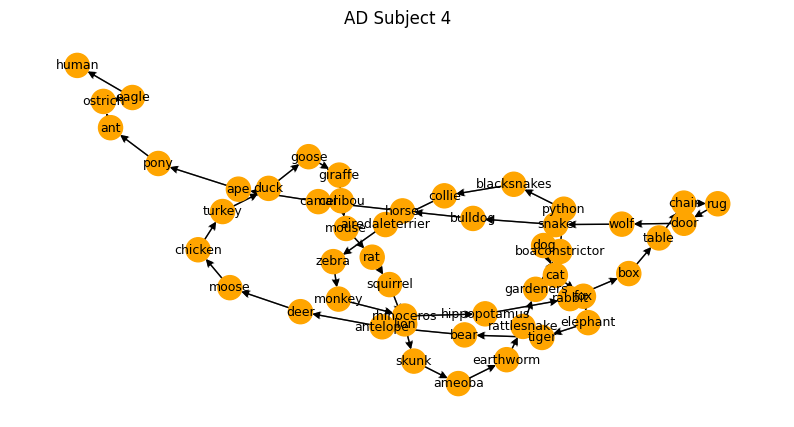

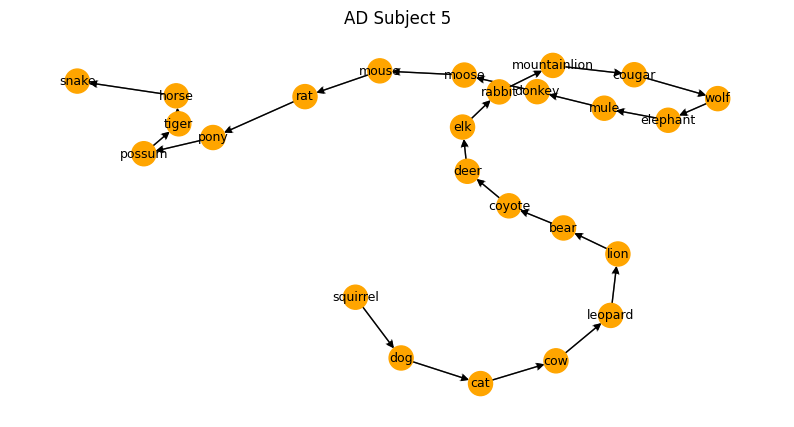

: 

: 

In [ ]:
# VISUALIZATION: plot the first 3 NC and first 3 AD graphs
for i in range(3):
    plot_transition_graph(nc_transition_graphs[i], nc_fluency_lists[i], title=f"NC Subject {i+1}")

for i in range(5):
    plot_transition_graph(ad_transition_graphs[i], ad_fluency_lists[i], title=f"AD Subject {i+1}")

### 4.3 Word-level transition networks METRICS

In [ ]:
# Define useful metrics for AD classification

def fluency_metrics(G, normalize_by_nodes=True):
    """
    Compute relevant metrics for a fluency transition graph with repeated words allowed.

    Parameters
    ----------
    G : nx.DiGraph or nx.Graph
        Transition graph of a fluency list (nodes = words, edges = transitions)
    normalize_by_nodes : bool, default True
        Whether to normalize metrics (except num_nodes) by number of nodes

    Returns
    -------
    metrics : dict
        Dictionary with computed metrics
    """
    metrics = {}

    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Basic counts
    metrics['num_nodes'] = num_nodes
    metrics['num_edges'] = num_edges

    # Degrees
    degs = np.array([d for n, d in G.degree(weight='weight')])
    metrics['avg_degree'] = degs.mean() if len(degs) > 0 else 0
    metrics['median_degree'] = np.median(degs) if len(degs) > 0 else 0

    # Density
    metrics['density'] = nx.density(G) if num_nodes > 1 else 0.0

    # Self-loop rate
    self_loops = G.number_of_selfloops() if hasattr(G, "number_of_selfloops") else sum(1 for u, v in G.edges() if u == v)
    metrics['self_loop_rate'] = self_loops / num_edges if num_edges > 0 else 0.0

    # --- Perseverations (total revisits of nodes) ---
    node_counts = {n: 0 for n in G.nodes()}
    for u, v, d in G.edges(data=True):
        node_counts[v] += d.get('weight', 1)
    revisits = [count - 1 for count in node_counts.values() if count > 1]
    metrics['perseverations'] = sum(revisits)

    # Number of repeated nodes
    metrics['num_repeated_nodes'] = sum(1 for count in node_counts.values() if count > 1)

    # Number of short cycles (length 2 or 3)
    cycles = list(nx.simple_cycles(G))
    short_cycles = [c for c in cycles if len(c) <= 3]
    metrics['num_short_cycles'] = len(short_cycles)

    # Longest unique path (without repeating nodes)
    try:
        longest_path = max(
            (p for source in G.nodes() for target in G.nodes() for p in nx.all_simple_paths(G, source, target)),
            key=len
        )
        metrics['longest_unique_path'] = len(longest_path)
    except ValueError:
        metrics['longest_unique_path'] = 0

    # Rates
    metrics['repetition_rate'] = self_loops / num_nodes if num_nodes > 0 else 0.0
    metrics['unique_path_rate'] = metrics['longest_unique_path'] / num_nodes if num_nodes > 0 else 0.0

    # --- Normalize all metrics by number of nodes if requested ---
    if normalize_by_nodes and num_nodes > 0:
        for key in metrics:
            if key != 'num_nodes':  # don't normalize node count itself
                metrics[key] /= num_nodes

    return metrics

: 

: 

In [ ]:
# Compute these metrics for AD and NC

nc_metrics = [fluency_metrics(G,normalize_by_nodes=False) for G in nc_transition_graphs]
ad_metrics = [fluency_metrics(G,normalize_by_nodes=False) for G in ad_transition_graphs]

nc_metrics_n = [fluency_metrics(G) for G in nc_transition_graphs]
ad_metrics_n = [fluency_metrics(G) for G in ad_transition_graphs]

# Convert to DataFrame

nc_df = pd.DataFrame(nc_metrics)
ad_df = pd.DataFrame(ad_metrics)
nc_df["group"] = "NC"
ad_df["group"] = "AD"

nc_df_n = pd.DataFrame(nc_metrics_n)
ad_df_n = pd.DataFrame(ad_metrics_n)
nc_df_n["group"] = "NC"
ad_df_n["group"] = "AD"

# Concatenate all three groups
df = pd.concat([nc_df, ad_df], ignore_index=True)
df_n = pd.concat([nc_df_n, ad_df_n], ignore_index=True)
df.head()

,num_nodes,num_edges,avg_degree,median_degree,density,self_loop_rate,perseverations,num_repeated_nodes,num_short_cycles,longest_unique_path,repetition_rate,unique_path_rate,group
0,22,21,1.909091,2.0,0.045455,0.0,0,0,0,22,0.0,1.0,NC
1,23,22,1.913043,2.0,0.043478,0.0,0,0,0,23,0.0,1.0,NC
2,98,97,1.979592,2.0,0.010204,0.0,0,0,0,98,0.0,1.0,NC
3,58,57,1.965517,2.0,0.017241,0.0,0,0,0,58,0.0,1.0,NC
4,64,63,1.968750,2.0,0.015625,0.0,0,0,0,64,0.0,1.0,NC


: 

: 

In [ ]:
summary = (
    df.groupby("group")
      .agg(["mean", "std"])
      .round(2)
)
print("\nSummary:")
print(summary)

summaryn = (
    df_n.groupby("group")
      .agg(["mean", "std"])
      .round(2)
)
print("\nSummary (Norm):")
print(summaryn)


Summary:
      num_nodes        num_edges        avg_degree       median_degree       \
           mean    std      mean    std       mean   std          mean  std   
group                                                                         
AD        26.44  12.96     25.44  12.96       1.90  0.05           2.0  0.0   
NC        61.07  26.60     60.07  26.60       1.96  0.02           2.0  0.0   

      density        ... num_repeated_nodes      num_short_cycles       \
         mean   std  ...               mean  std             mean  std   
group                ...                                                 
AD       0.05  0.03  ...                0.0  0.0              0.0  0.0   
NC       0.02  0.01  ...                0.0  0.0              0.0  0.0   

      longest_unique_path        repetition_rate      unique_path_rate       
                     mean    std            mean  std             mean  std  
group                                                              

: 

: 

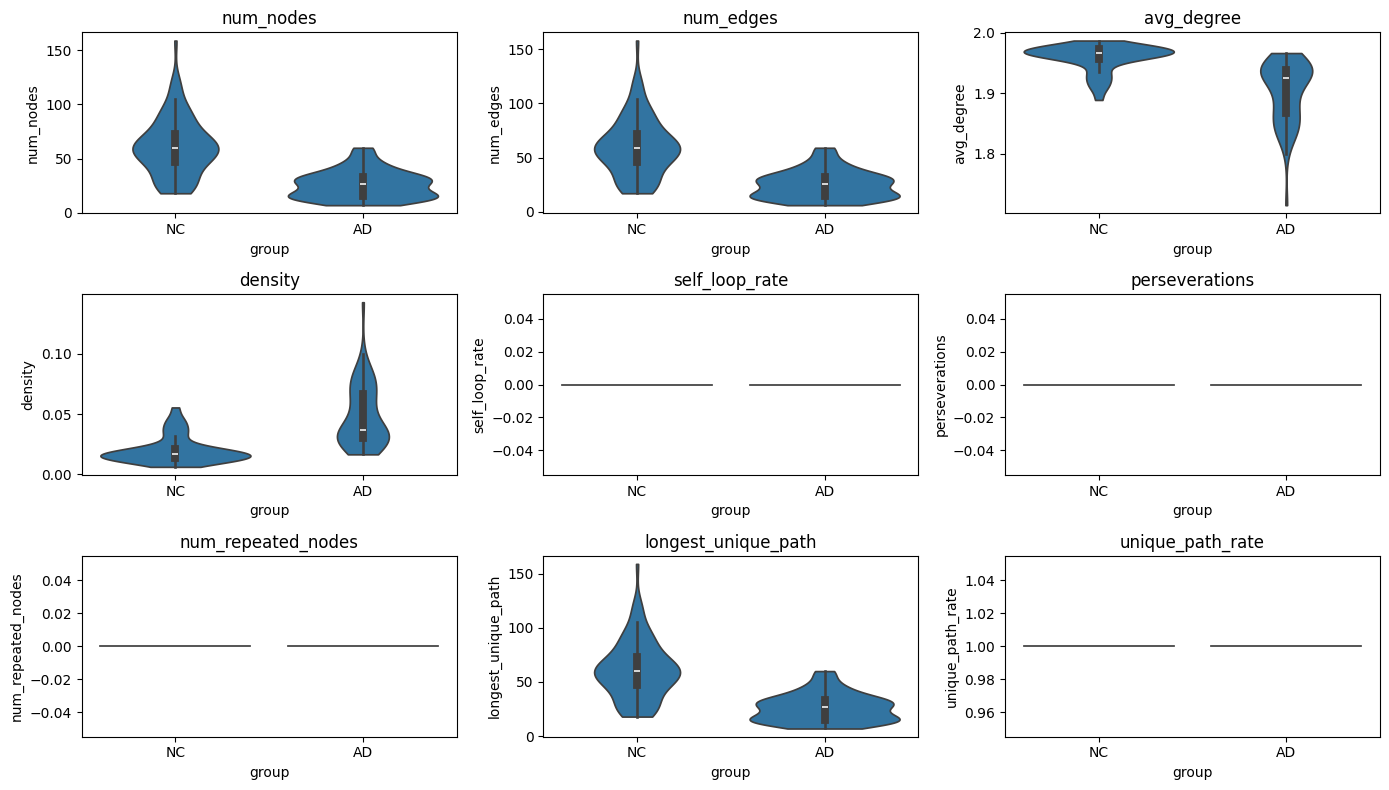

: 

: 

In [ ]:
# VISUALIZATION

metrics_to_plot = [
    "num_nodes",           # vocabulary size
    "num_edges",           # total transitions
    "avg_degree",          # mean connectivity
    "density",             # network connectivity
    "self_loop_rate",      # immediate repetitions
    "perseverations",      # repeated words
    "num_repeated_nodes",  # number of looping words
    "longest_unique_path", # ability to produce diverse sequences
    "unique_path_rate"
]

plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(3, 3, i)
    sns.violinplot(
        data=df,
        x="group",
        y=metric,
        inner="box",
        cut=0
    )
    plt.title(metric)

plt.tight_layout()
plt.show()

### 4.4 Subcategory-level transition networks

In [ ]:
ANIMAL_CATEGORIES = {
    # Pets
    "cat": "pet", "dog": "pet", "kitten": "pet", "puppy": "pet", "hamster": "pet",
    "guineapig": "pet", "ferret": "pet", "rabbit": "pet", "bunny": "pet", "manx": "pet",

    # Farm / livestock
    "cow": "farm", "sheep": "farm", "goat": "farm", "pig": "farm", "ox": "farm",
    "horse": "farm", "pony": "farm", "mule": "farm", "donkey": "farm", "waterbuffalo": "farm",
    "chicken": "farm", "goose": "farm", "bison": "farm", "buffalo": "farm",

    # Big cats
    "lion": "big_cat", "tiger": "big_cat", "leopard": "big_cat", "cougar": "big_cat",
    "mountainlion": "big_cat", "cheetah": "big_cat", "blackpanther": "big_cat",

    # Primates
    "chimpanzee": "primate", "orangutan": "primate", "baboon": "primate", "gorilla": "primate",
    "monkey": "primate",

    # Hooved herbivores (ungulates)
    "elephant": "ungulate", "giraffe": "ungulate", "zebra": "ungulate", "hippopotamus": "ungulate",
    "moose": "ungulate", "camel": "ungulate", "antelope": "ungulate", "reindeer": "ungulate",
    "gnu": "ungulate", "horse": "ungulate", "pony": "ungulate", "mule": "ungulate", "donkey": "ungulate",
    "waterbuffalo": "ungulate", "cow": "ungulate", "sheep": "ungulate", "goat": "ungulate", "ox": "ungulate",
    "bison": "ungulate", "deer": "ungulate", "gazelle": "ungulate",

    # Canids
    "wolf": "canid", "fox": "canid", "coyote": "canid",

    # Bears
    "bear": "bear", "brownbear": "bear", "grizzlybear": "bear", "blackbear": "bear", "polarbear": "bear",

    # Hyenas
    "hyena": "hyena",

    # Small omnivores
    "raccoon": "small_omnivore", "skunk": "small_omnivore", "aardvark": "small_omnivore", "muskrat": "small_omnivore",

    # Marsupials
    "kangaroo": "marsupial", "possum": "marsupial", "koala": "marsupial",

    # Birds
    "bird": "bird", "pigeon": "bird", "peacock": "bird", "eagle": "bird", "condor": "bird",
    "parrot": "bird", "finch": "bird", "swallow": "bird", "sparrow": "bird", "owl": "bird",
    "penguin": "bird", "ostrich": "bird", "dove": "bird", "robin": "bird", "seagull": "bird",
    "woodpecker": "bird", "blackbird": "bird", "redbird": "bird", "meadowlark": "bird",
    "parakeet": "bird", "hen": "bird", "mockingbird": "bird", "pelican": "bird",
    "sandpiper": "bird",

    # Aquatic
    "whale": "aquatic", "dolphin": "aquatic", "seal": "aquatic", "sealion": "aquatic",
    "otter": "aquatic", "porpoise": "aquatic", "piranha": "aquatic", "fish": "aquatic",
    "cod": "aquatic", "sardine": "aquatic", "tuna": "aquatic", "trout": "aquatic",
    "halibut": "aquatic", "lobster": "aquatic", "shrimp": "aquatic", "clam": "aquatic",
    "oyster": "aquatic", "scallop": "aquatic", "guppy": "aquatic", "tadpole": "aquatic",
    "frog": "aquatic", "newt": "aquatic",

    # Reptiles
    "alligator": "reptile", "crocodile": "reptile", "snake": "reptile", "cobra": "reptile",
    "tortoise": "reptile", "turtle": "reptile", "rattlesnake": "reptile",

    # Insects / small critters
    "ant": "insect", "cockroach": "insect", "flea": "insect", "mite": "insect",
    "mosquito": "insect", "termite": "insect", "bee": "insect", "fly": "insect",
    "bug": "insect", "panah": "insect", "tick": "insect", "butterfly": "insect",

    # Rodent
    "rat": "rodent", "mouse": "rodent", "prairiedog": "rodent",
    "squirrel": "rodent", "gerbil": "rodent", "chinchilla": "rodent", "rodents": "rodent",

    # Other / unknown
    "human": "unknown", "q": "unknown", "fidge": "unknown", "pen": "unknown",
    "slup": "unknown"
}

: 

: 

In [ ]:
def map_to_categories(fluency_dict, category_map):
    """
    Map words in a fluency dictionary to their categories.
    Non-string items are mapped to 'unknown'.
    """
    mapped = []
    for w in fluency_dict.values():  # use values, not keys
        if isinstance(w, str):
            mapped.append(category_map.get(w.lower(), "unknown"))
        else:
            mapped.append("unknown")
    return mapped

def build_subcategory_network(fluency_categories):
    """
    Build a directed transition network of subcategories from a fluency trial.

    Parameters
    ----------
    fluency_categories : list of str
        List of subcategory labels for a participant.

    Returns
    -------
    G : nx.DiGraph
        Directed graph with nodes=subcategories and edges=transitions.
        Edge weights indicate repeated transitions.
    """
    G = nx.DiGraph()

    for i in range(len(fluency_categories) - 1):
        u = fluency_categories[i]
        v = fluency_categories[i + 1]
        if G.has_edge(u, v):
            G[u][v]['weight'] += 1
        else:
            G.add_edge(u, v, weight=1)

    # Make sure all subcategories appear as nodes even if no outgoing edge
    for cat in set(fluency_categories):
        if cat not in G:
            G.add_node(cat)

    return G

: 

: 

In [ ]:
# Apply to all NC fluency dictionaries
nc_fluency_categories = [
    map_to_categories(d, ANIMAL_CATEGORIES)
    for d in nc_fluency_lists2
]

# Apply to all AD fluency dictionaries
ad_fluency_categories = [
    map_to_categories(d, ANIMAL_CATEGORIES)
    for d in ad_fluency_lists2
]

#create networks for all NC participants
nc_subcat_networks = [build_subcategory_network(lst) for lst in nc_fluency_categories]

#create networks for all AD participants
ad_subcat_networks = [build_subcategory_network(lst) for lst in ad_fluency_categories]

: 

: 

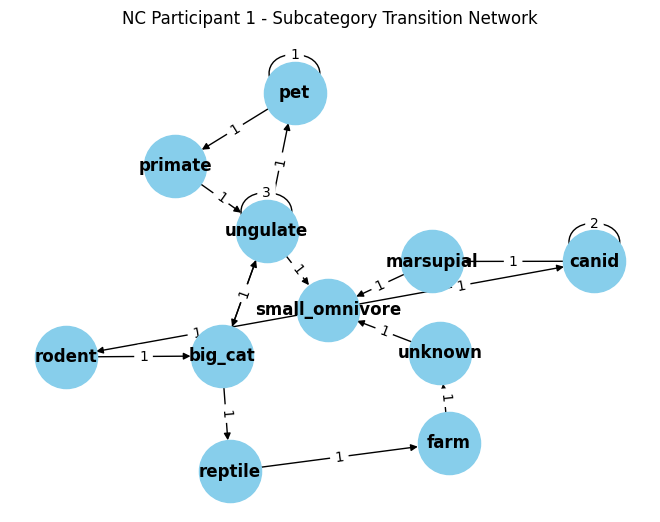

: 

: 

In [ ]:
# VISUALIZATION
G = nc_subcat_networks[0]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("NC Participant 1 - Subcategory Transition Network")
plt.show()

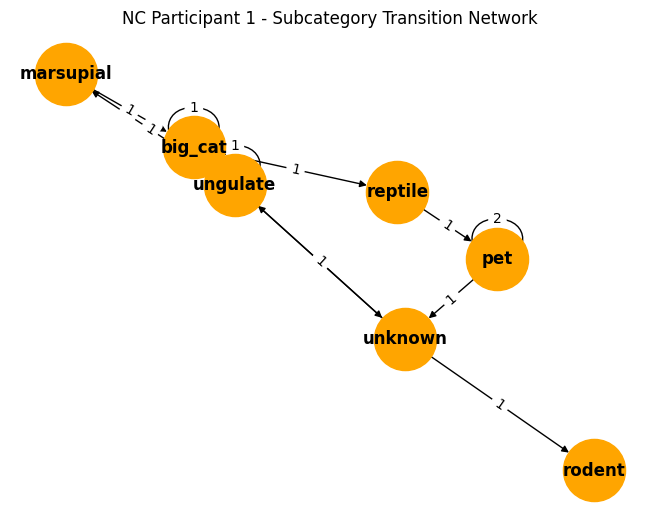

: 

: 

In [ ]:
G = ad_subcat_networks[0]
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_color='orange', node_size=2000, font_size=12, font_weight='bold')
edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
plt.title("NC Participant 1 - Subcategory Transition Network")
plt.show()

### 4.5 Subcategory-level transition networks METRICS

In [ ]:
def subcategory_network_metrics(G, normalize_by_nodes=False):
    """
    Compute relevant metrics for a subcategory transition graph
    (node = subcategory, edge = transition between categories).

    Parameters
    ----------
    G : nx.DiGraph
        Directed graph where nodes = subcategories, edges = transitions.
    normalize_by_nodes : bool, default False
        Whether to normalize metrics (except num_subcategories) by the number of nodes.

    Returns
    -------
    metrics : dict
        Dictionary with computed metrics.
    """
    metrics = {}

    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    # Basic counts
    metrics['num_subcategories'] = num_nodes
    metrics['num_transitions'] = num_edges

    # Average and median degree (weighted)
    degrees = np.array([d for n, d in G.degree(weight='weight')])
    metrics['avg_degree'] = degrees.mean() if len(degrees) > 0 else 0
    metrics['median_degree'] = np.median(degrees) if len(degrees) > 0 else 0

    # Density
    metrics['density'] = nx.density(G) if num_nodes > 1 else 0

    # Self-loop rate
    self_loops = sum(1 for u, v in G.edges() if u == v)
    metrics['self_loop_rate'] = self_loops / num_edges if num_edges > 0 else 0

    # Repeated categories (nodes revisited more than once)
    node_visits = {n: 0 for n in G.nodes()}
    for u, v in G.edges():
        node_visits[v] += G[u][v].get('weight', 1)
    metrics['num_repeated_categories'] = sum(1 for count in node_visits.values() if count > 1)

    # Longest unique path
    try:
        longest_path = max(
            (p for source in G.nodes() for target in G.nodes()
             for p in nx.all_simple_paths(G, source, target)),
            key=len
        )
        metrics['longest_unique_path'] = len(longest_path)
    except ValueError:
        metrics['longest_unique_path'] = 0

    # Jump count (transitions between different categories)
    jump_count = sum(1 for u, v in G.edges() if u != v)
    metrics['jump_count'] = jump_count

    # Normalize if requested (skip num_subcategories)
    if normalize_by_nodes and num_nodes > 0:
        for key in metrics:
            if key != 'num_subcategories':
                metrics[key] /= num_nodes

    return metrics

: 

: 

In [ ]:
# Compute metrics WITHOUT normalization
nc_subcat_metrics = [subcategory_network_metrics(G, normalize_by_nodes=False) for G in nc_subcat_networks]
ad_subcat_metrics = [subcategory_network_metrics(G, normalize_by_nodes=False) for G in ad_subcat_networks]

# Compute metrics WITH normalization by nodes
nc_subcat_metrics_n = [subcategory_network_metrics(G, normalize_by_nodes=True) for G in nc_subcat_networks]
ad_subcat_metrics_n = [subcategory_network_metrics(G, normalize_by_nodes=True) for G in ad_subcat_networks]

# Convert to DataFrame
df_nc_subcat = pd.DataFrame(nc_subcat_metrics)
df_nc_subcat['group'] = 0  # NC

df_ad_subcat = pd.DataFrame(ad_subcat_metrics)
df_ad_subcat['group'] = 1  # AD

df_nc_subcatn = pd.DataFrame(nc_subcat_metrics_n)
df_nc_subcatn['group'] = 0  # NC

df_ad_subcatn = pd.DataFrame(ad_subcat_metrics_n)
df_ad_subcatn['group'] = 1  # AD

# Combine
df_subcat = pd.concat([df_nc_subcat, df_ad_subcat], ignore_index=True)
df_subcat_n = pd.concat([df_nc_subcatn, df_ad_subcatn], ignore_index=True)

# Show summary
print(df_subcat.groupby('group').mean())
print(df_subcat_n.groupby('group').mean())

       num_subcategories  num_transitions  avg_degree  median_degree  \
group                                                                  
0              13.237113        37.845361    8.821468       5.159794   
1               9.442623        19.377049    5.134999       3.516393   

        density  self_loop_rate  num_repeated_categories  longest_unique_path  \
group                                                                           
0      0.231608        0.167128                10.030928            11.164948   
1      0.256732        0.191716                 5.327869             7.868852   

       jump_count  
group              
0       31.721649  
1       15.803279  
       num_subcategories  num_transitions  avg_degree  median_degree  \
group                                                                  
0              13.237113         2.807533    0.662530       0.391062   
1               9.442623         1.990450    0.567791       0.402068   

        density  

: 

: 

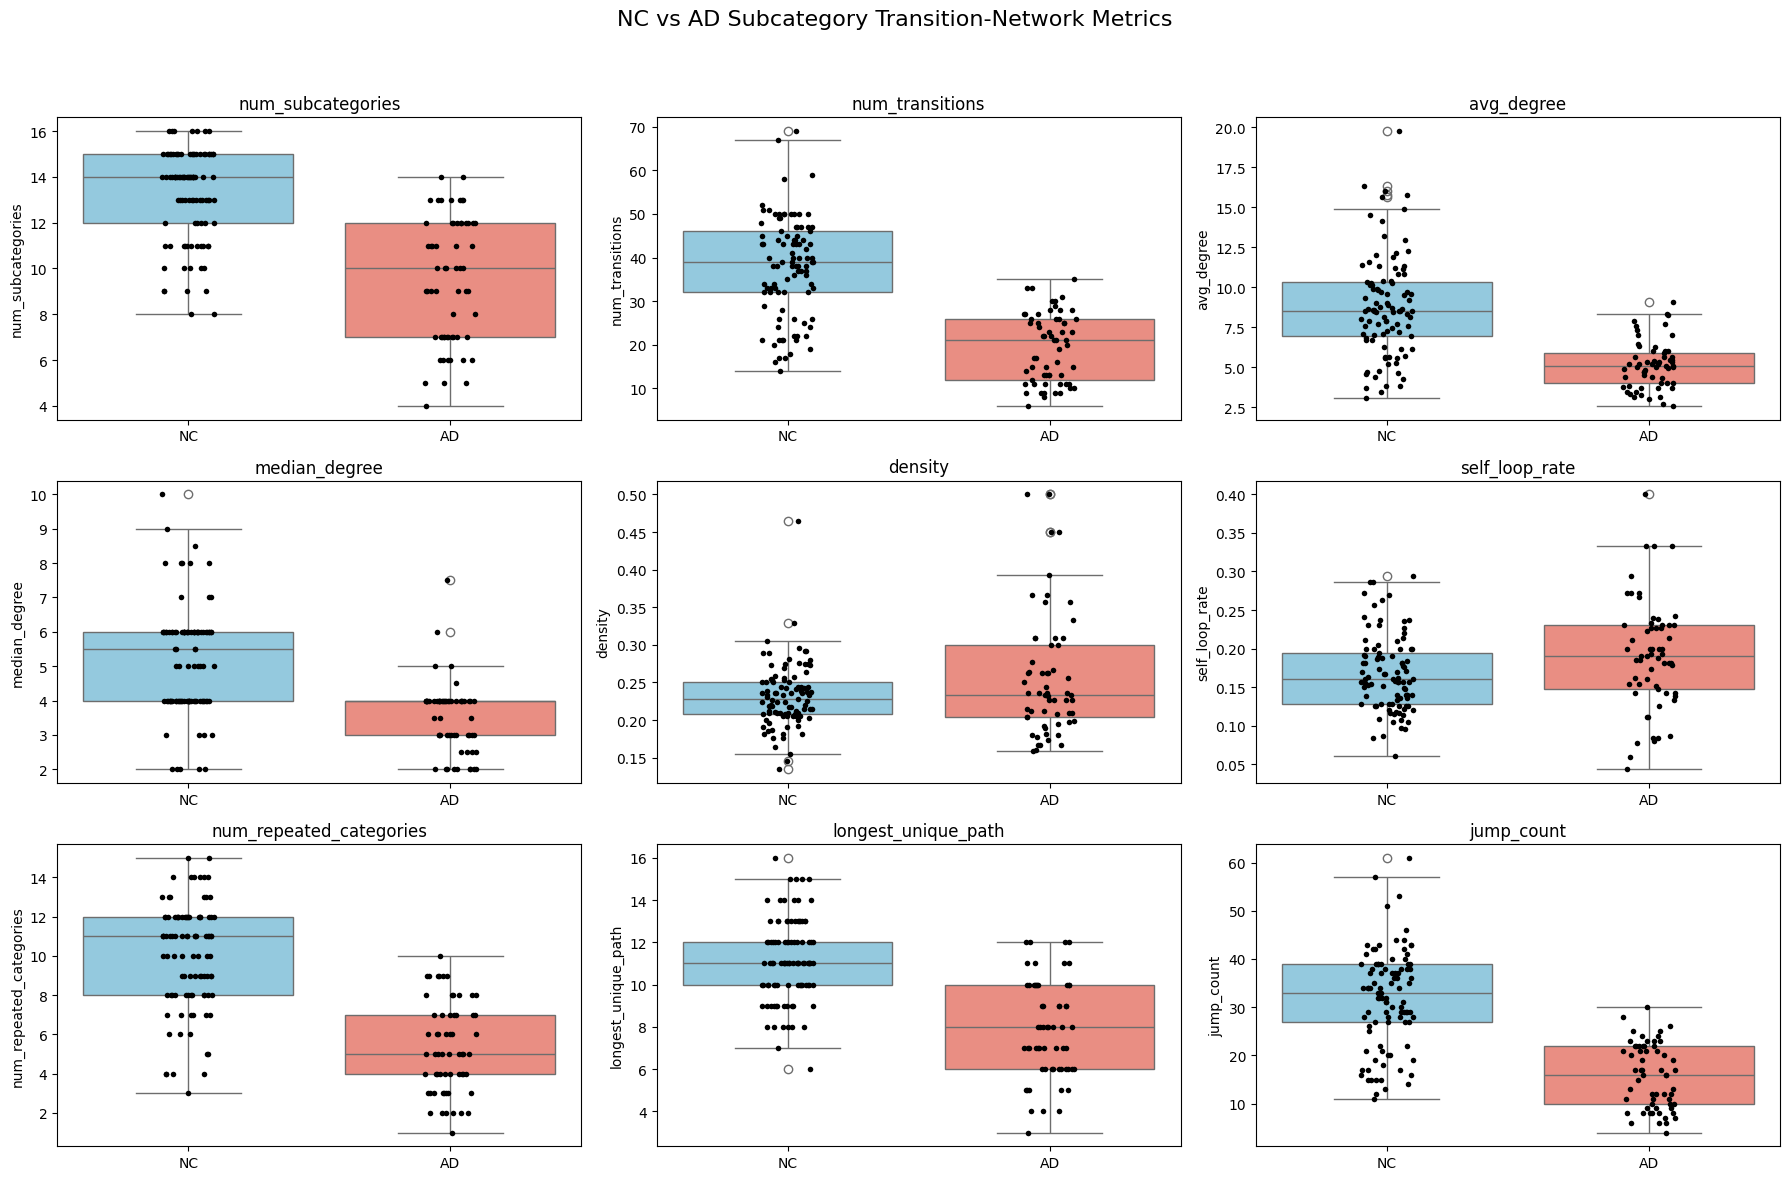

: 

: 

In [ ]:
# VISUALIZATION
metrics_to_plot = [
    "num_subcategories",
    "num_transitions",
    "avg_degree",
    "median_degree",
    "density",
    "self_loop_rate",
    "num_repeated_categories",
    "longest_unique_path",
    "jump_count"
]

# Prepare subplots
rows, cols = 3, 3
fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
axes = axes.flatten()

# Map group for better labels
group_labels = {0: "NC", 1: "AD"}
df_subcat['group_label'] = df_subcat['group'].map(group_labels)

# Plot each metric
for ax, metric in zip(axes, metrics_to_plot):
    sns.boxplot(
        x="group_label",
        y=metric,
        hue="group_label",      # Fix for future warning
        data=df_subcat,
        palette=["skyblue", "salmon"],
        dodge=False,
        ax=ax,
        legend=False            # Remove duplicate legend
    )
    sns.stripplot(
        x="group_label",
        y=metric,
        data=df_subcat,
        color="black",
        size=4,
        jitter=True,
        ax=ax
    )
    ax.set_title(metric, fontsize=12)
    ax.set_xlabel("")
    ax.set_ylabel(metric)

plt.suptitle("NC vs AD Subcategory Transition-Network Metrics", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

 Feature Preparation and Normalization


### 4.6 Classification and Statistical Analysis


Word-level transition networks MODELS

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.59      0.83      0.69        12

    accuracy                           0.72        32
   macro avg       0.73      0.74      0.72        32
weighted avg       0.76      0.72      0.72        32



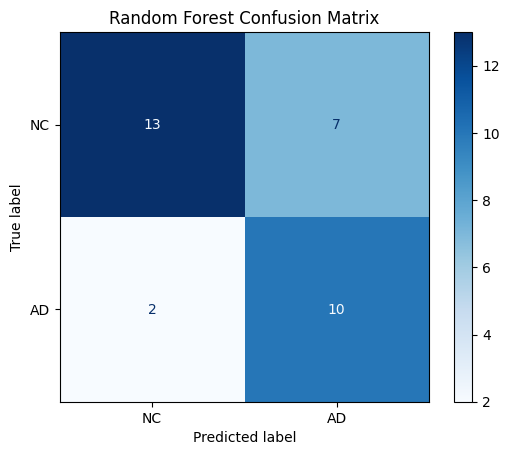


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.67      1.00      0.80        12

    accuracy                           0.81        32
   macro avg       0.83      0.85      0.81        32
weighted avg       0.88      0.81      0.81        32



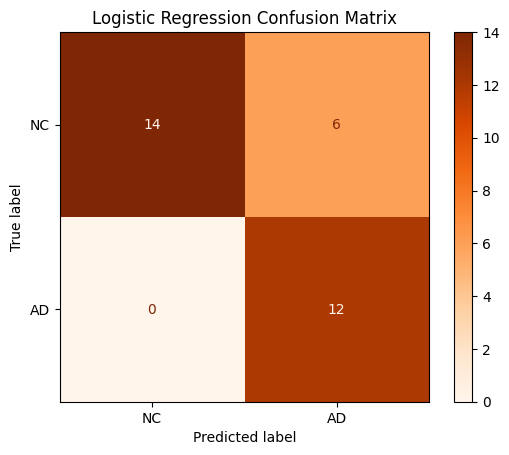

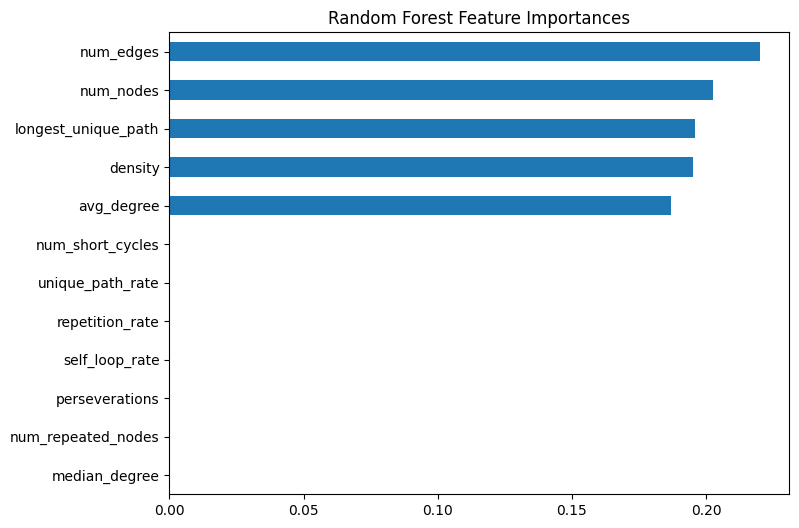

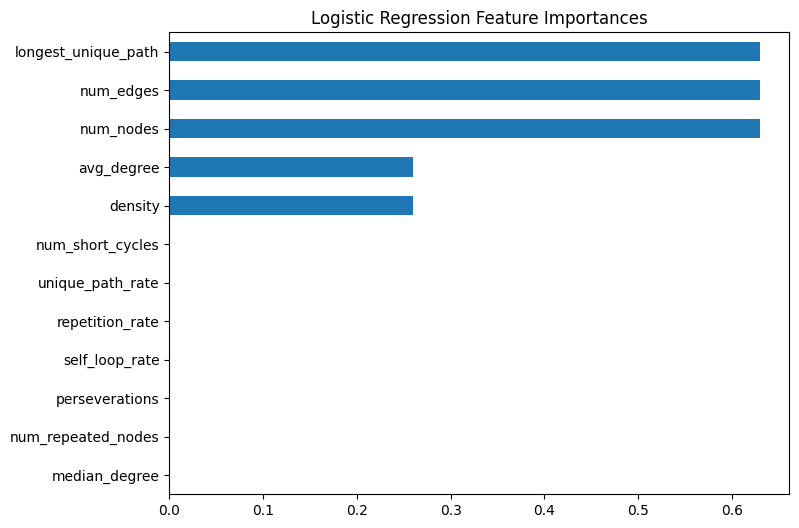

LOOCV accuracy: 0.7468354430379747


: 

: 

In [ ]:
# 1. Prepare features and labels ---

# nc_metrics and ad_metrics are lists of dicts with the network metrics
nc_df = pd.DataFrame(nc_metrics)
ad_df = pd.DataFrame(ad_metrics)

# Assign labels
nc_df['label'] = 0  # NC = 0
ad_df['label'] = 1  # AD = 1

# Combine data
df = pd.concat([nc_df, ad_df], ignore_index=True)
X = df.drop(columns=['label'])
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train classifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train, y_train)

# 4. Performance Evaluation
print("Random Forest Performance:")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['NC', 'AD'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nLogistic Regression Performance:")
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['NC', 'AD'])
disp_lr.plot(cmap=plt.cm.Oranges)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# 5. Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Random Forest Feature Importances")
plt.show()
feature_importances = pd.Series(np.abs(lr.coef_[0]), index=X.columns)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Logistic Regression Feature Importances")
plt.show()

# 6. Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(rf, X_scaled, y, cv=loo)
print("LOOCV accuracy:", scores.mean())


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.87      0.65      0.74        20
           1       0.59      0.83      0.69        12

    accuracy                           0.72        32
   macro avg       0.73      0.74      0.72        32
weighted avg       0.76      0.72      0.72        32

[[13  7]
 [ 2 10]]


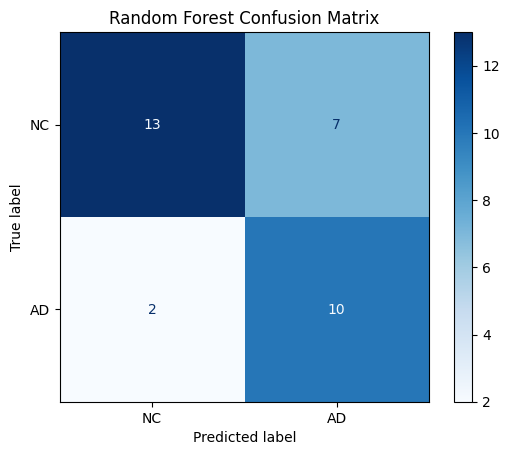


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       1.00      0.70      0.82        20
           1       0.67      1.00      0.80        12

    accuracy                           0.81        32
   macro avg       0.83      0.85      0.81        32
weighted avg       0.88      0.81      0.81        32

[[14  6]
 [ 0 12]]


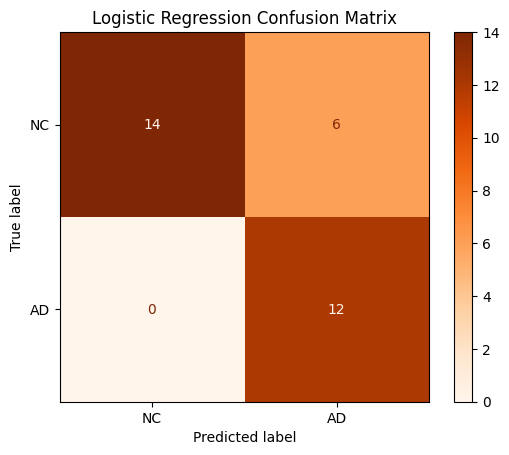

num_nodes              0.177757
num_edges              0.168369
avg_degree             0.184617
median_degree          0.170382
density                0.160212
self_loop_rate         0.000000
perseverations         0.000000
num_repeated_nodes     0.000000
num_short_cycles       0.000000
longest_unique_path    0.000000
repetition_rate        0.000000
unique_path_rate       0.138664
dtype: float64


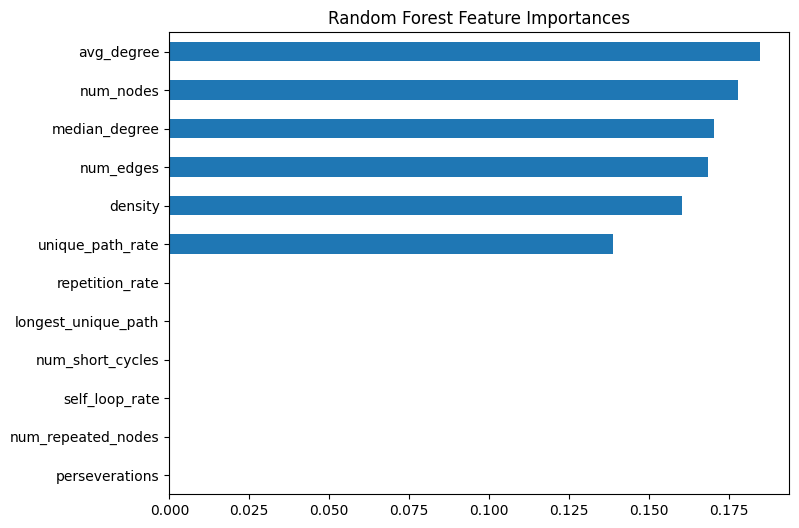

num_nodes              1.425252
num_edges              0.178616
avg_degree             0.171096
median_degree          0.178616
density                0.229980
self_loop_rate         0.000000
perseverations         0.000000
num_repeated_nodes     0.000000
num_short_cycles       0.000000
longest_unique_path    0.000000
repetition_rate        0.000000
unique_path_rate       0.178616
dtype: float64


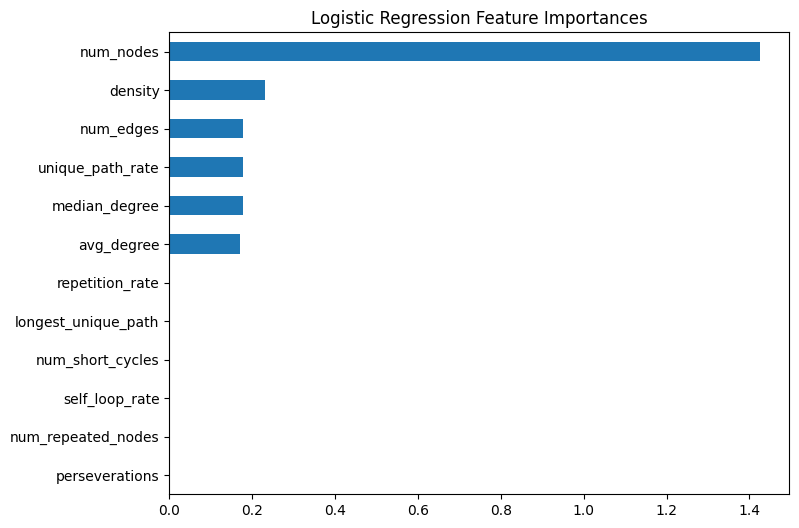

LOOCV accuracy: 0.7531645569620253


: 

: 

In [ ]:
# 1. Prepare features and labels ---

# nc_metrics and ad_metrics are lists of dicts with the network metrics
nc_df = pd.DataFrame(nc_metrics_n)
ad_df = pd.DataFrame(ad_metrics_n)

# Assign labels
nc_df['label'] = 0  # NC = 0
ad_df['label'] = 1  # AD = 1

# Combine data
df = pd.concat([nc_df, ad_df], ignore_index=True)
X = df.drop(columns=['label'])
y = df['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train classifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train, y_train)

# 4. Performance Evaluation
print("Random Forest Performance:")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['NC', 'AD'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nLogistic Regression Performance:")
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['NC', 'AD'])
disp_lr.plot(cmap=plt.cm.Oranges)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# 5. Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print(feature_importances)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Random Forest Feature Importances")
plt.show()
feature_importances = pd.Series(np.abs(lr.coef_[0]), index=X.columns)
print(feature_importances)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Logistic Regression Feature Importances")
plt.show()



# 6. Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(rf, X_scaled, y, cv=loo)
print("LOOCV accuracy:", scores.mean())

Subcategory-level transition network

Random Forest Performance:
              precision    recall  f1-score   support

           0       0.89      0.80      0.84        20
           1       0.71      0.83      0.77        12

    accuracy                           0.81        32
   macro avg       0.80      0.82      0.81        32
weighted avg       0.82      0.81      0.81        32

[[14  6]
 [ 0 12]]


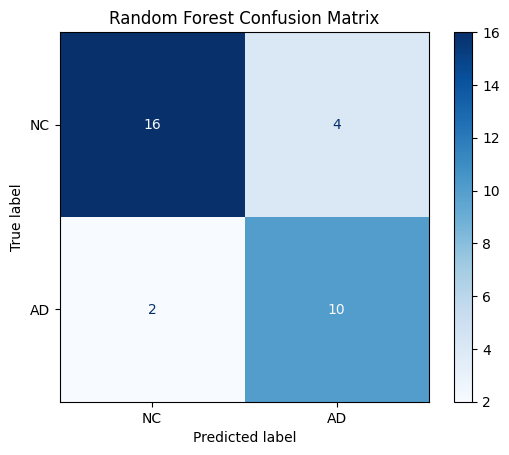


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        20
           1       0.67      0.67      0.67        12

    accuracy                           0.75        32
   macro avg       0.73      0.73      0.73        32
weighted avg       0.75      0.75      0.75        32

[[16  4]
 [ 4  8]]


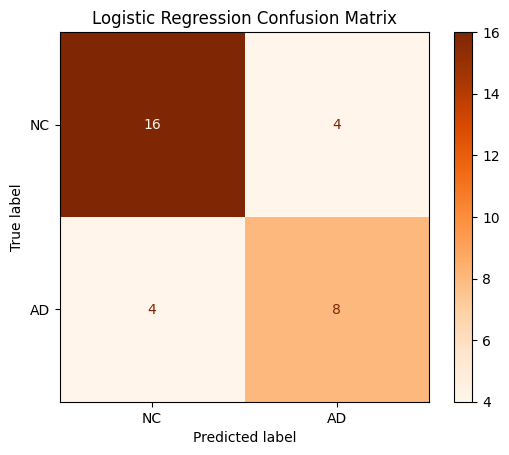

num_subcategories          0.127172
num_transitions            0.245016
avg_degree                 0.066088
median_degree              0.053211
density                    0.073513
self_loop_rate             0.062600
num_repeated_categories    0.122277
longest_unique_path        0.033532
jump_count                 0.216590
dtype: float64


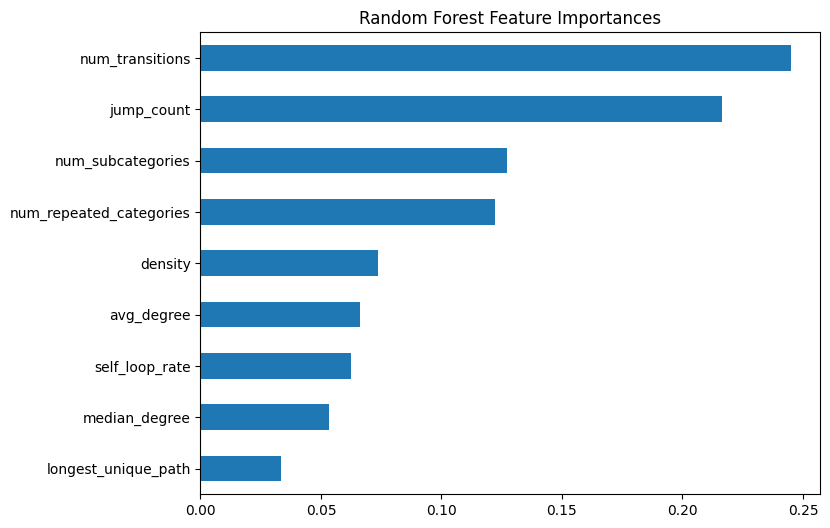

num_subcategories          0.622861
num_transitions            0.717505
avg_degree                 0.051193
median_degree              0.533136
density                    0.745082
self_loop_rate             0.325761
num_repeated_categories    0.733887
longest_unique_path        0.470070
jump_count                 0.636419
dtype: float64


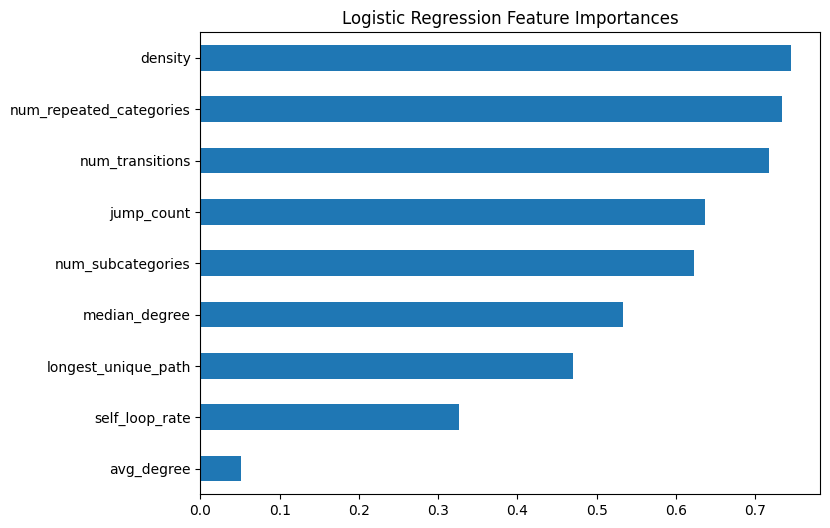

LOOCV accuracy: 0.8734177215189873


: 

: 

In [ ]:
# 1. Prepare features and labels ---

# nc_metrics and ad_metrics are lists of dicts with the network metrics
#df_nc_subcat = pd.DataFrame(nc_subcat_metrics)
#df_ad_subcat = pd.DataFrame(ad_subcat_metrics)

df_nc_subcat = pd.DataFrame(nc_subcat_metrics_n)
df_ad_subcat = pd.DataFrame(ad_subcat_metrics_n)

# Assign labels
df_nc_subcat['label'] = 0  # NC
df_ad_subcat['label'] = 1  # AD

# Combine data
df_subcat = pd.concat([df_nc_subcat, df_ad_subcat], ignore_index=True)
X = df_subcat.drop(columns=['label'])
y = df_subcat['label']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Train classifier

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train, y_train)

# 4. Performance Evaluation
print("Random Forest Performance:")
y_pred_rf = rf.predict(X_test)
print(classification_report(y_test, y_pred_rf))
cm_rf = confusion_matrix(y_test, y_pred_rf)
print(cm_lr )
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=['NC', 'AD'])
disp_rf.plot(cmap=plt.cm.Blues)
plt.title("Random Forest Confusion Matrix")
plt.show()

print("\nLogistic Regression Performance:")
y_pred_lr = lr.predict(X_test)
print(classification_report(y_test, y_pred_lr))
cm_lr = confusion_matrix(y_test, y_pred_lr)
print(cm_lr )
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=['NC', 'AD'])
disp_lr.plot(cmap=plt.cm.Oranges)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# 5. Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=X.columns)
print(feature_importances)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Random Forest Feature Importances")
plt.show()
feature_importances = pd.Series(np.abs(lr.coef_[0]), index=X.columns)
print(feature_importances)
feature_importances.sort_values().plot(kind='barh', figsize=(8, 6))
plt.title("Logistic Regression Feature Importances")
plt.show()

# 6. Cross-Validation
loo = LeaveOneOut()
scores = cross_val_score(rf, X_scaled, y, cv=loo)
print("LOOCV accuracy:", scores.mean())


Combine the word-level features with the subcategory-level features

Random Forest LOOCV Performance:
              precision    recall  f1-score   support

           0       0.86      0.89      0.87        97
           1       0.81      0.77      0.79        61

    accuracy                           0.84       158
   macro avg       0.84      0.83      0.83       158
weighted avg       0.84      0.84      0.84       158

    NC  AD
NC  86  11
AD  14  47


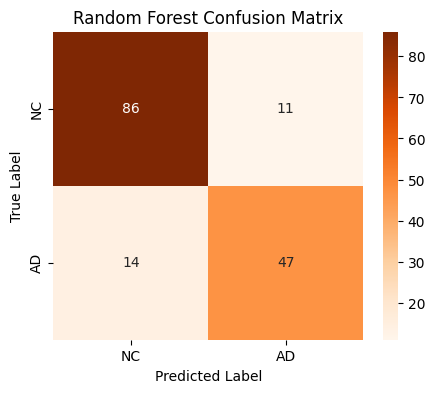

Logistic Regression LOOCV Performance:
              precision    recall  f1-score   support

           0       0.82      0.87      0.84        97
           1       0.77      0.70      0.74        61

    accuracy                           0.80       158
   macro avg       0.80      0.79      0.79       158
weighted avg       0.80      0.80      0.80       158

    NC  AD
NC  84  13
AD  18  43


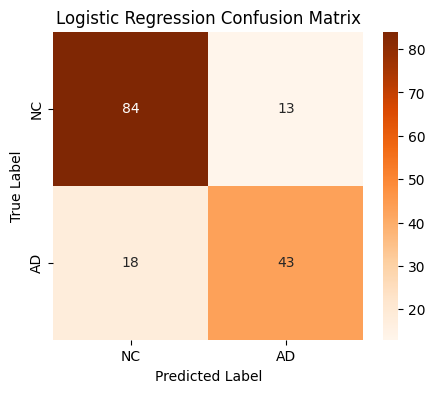

num_nodes                  0.082675
num_edges                  0.065063
avg_degree                 0.088179
median_degree              0.074973
density                    0.051013
self_loop_rate             0.000000
perseverations             0.000000
num_repeated_nodes         0.000000
num_short_cycles           0.000000
longest_unique_path        0.000000
repetition_rate            0.000000
unique_path_rate           0.073953
num_subcategories          0.040095
num_transitions            0.086751
avg_degree                 0.029464
median_degree              0.036650
density                    0.050502
self_loop_rate             0.048899
num_repeated_categories    0.075577
longest_unique_path        0.039823
jump_count                 0.156384
dtype: float64


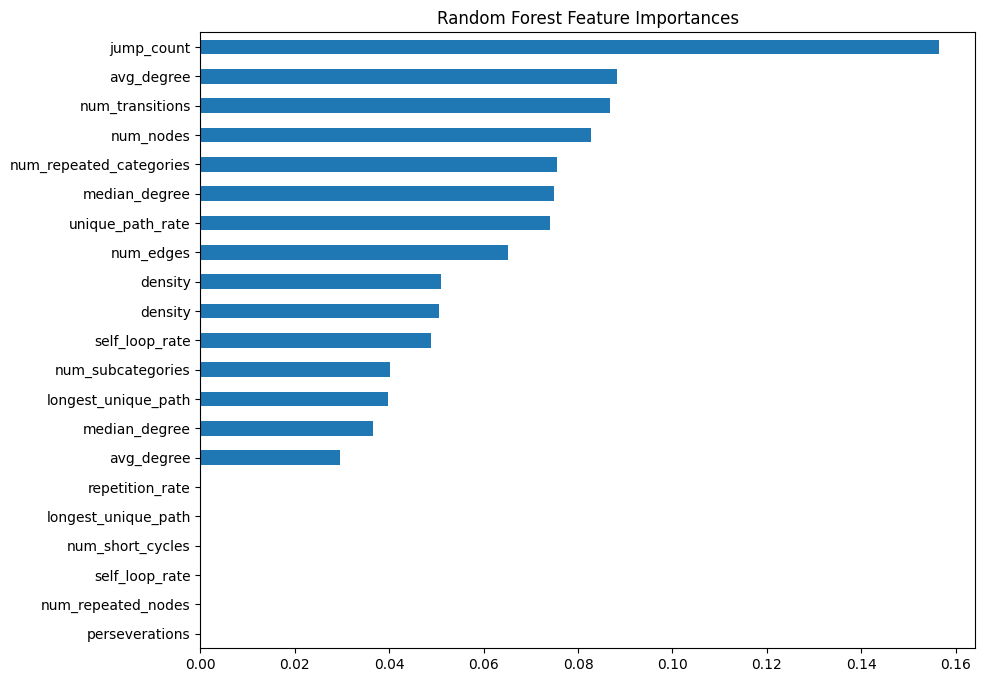

num_nodes                  0.670474
num_edges                  0.257284
avg_degree                 0.324497
median_degree              0.257284
density                    0.321998
self_loop_rate             0.000000
perseverations             0.000000
num_repeated_nodes         0.000000
num_short_cycles           0.000000
longest_unique_path        0.000000
repetition_rate            0.000000
unique_path_rate           0.257284
num_subcategories          0.551112
num_transitions            0.908435
avg_degree                 0.292009
median_degree              0.447698
density                    0.941812
self_loop_rate             0.527621
num_repeated_categories    0.487767
longest_unique_path        0.346650
jump_count                 0.576581
dtype: float64


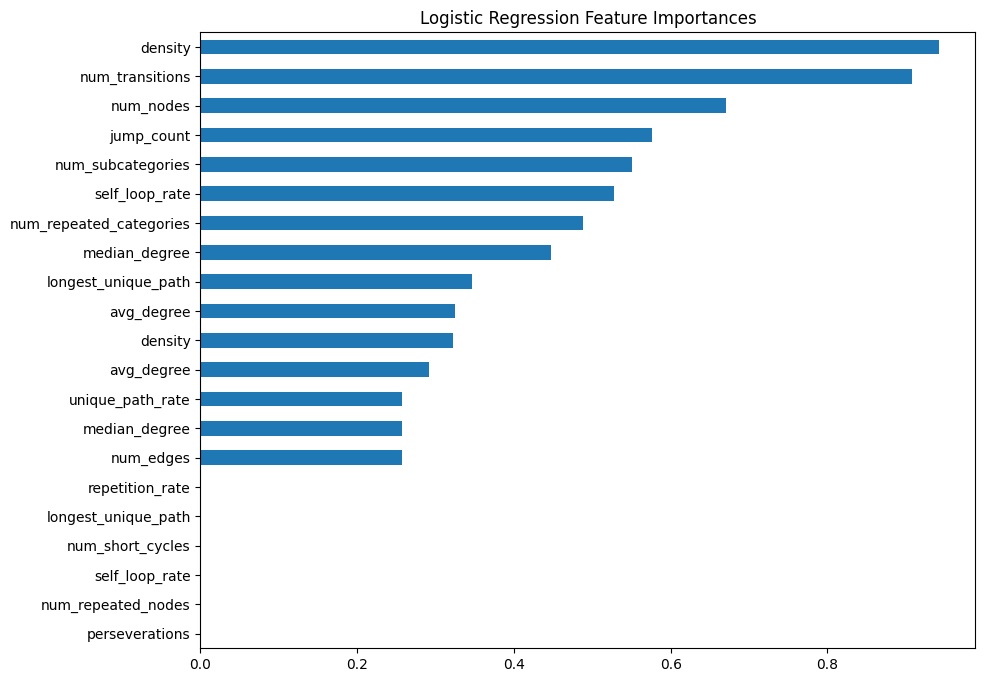

: 

: 

In [ ]:
# 1. convert metric to datadrame
# Word-level features
nc_word_df = pd.DataFrame(nc_metrics_n)
ad_word_df = pd.DataFrame(ad_metrics_n)

# Subcategory-level features (normalized by nodes)
nc_subcat_df = pd.DataFrame(nc_subcat_metrics_n)
ad_subcat_df = pd.DataFrame(ad_subcat_metrics_n)

# ADD labels
nc_word_df['label'] = 0  # NC
ad_word_df['label'] = 1  # AD

nc_subcat_df['label'] = 0
ad_subcat_df['label'] = 1

# Combine NC features
nc_combined = pd.concat([nc_word_df.reset_index(drop=True).drop(columns=['label']),
                         nc_subcat_df.reset_index(drop=True).drop(columns=['label'])],
                        axis=1)
nc_combined['label'] = 0  # NC label

# Combine AD features
ad_combined = pd.concat([ad_word_df.reset_index(drop=True).drop(columns=['label']),
                         ad_subcat_df.reset_index(drop=True).drop(columns=['label'])],
                        axis=1)
ad_combined['label'] = 1  # AD label

#combine all participants
df_combined = pd.concat([nc_combined, ad_combined], ignore_index=True)

#Split into features and labels
X = df_combined.drop(columns=['label'])
y = df_combined['label']

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 2. LOOCV Evaluation
# ---------------------------
loo = LeaveOneOut()
y_true = []
y_pred_rf = []
y_pred_lr = []

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
lr_model = LogisticRegression(max_iter=500, random_state=42)

for train_idx, test_idx in loo.split(X_scaled):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test_single = y.iloc[train_idx], y.iloc[test_idx]

    # Train Random Forest
    rf_model.fit(X_train, y_train)
    y_pred_rf.append(rf_model.predict(X_test)[0])

    # Train Logistic Regression
    lr_model.fit(X_train, y_train)
    y_pred_lr.append(lr_model.predict(X_test)[0])

    y_true.append(y_test_single.values[0])

y_true = np.array(y_true)
y_pred_rf = np.array(y_pred_rf)
y_pred_lr = np.array(y_pred_lr)

# ---------------------------
# 3. Confusion Matrices
# ---------------------------
def plot_confusion_heatmap(y_true, y_pred, labels=['NC', 'AD'], title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    print(cm_df)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

# cmap=plt.cm.Oranges
# Random Forest
print("Random Forest LOOCV Performance:")
print(classification_report(y_true, y_pred_rf))
plot_confusion_heatmap(y_true, y_pred_rf, title="Random Forest Confusion Matrix")

# Logistic Regression
print("Logistic Regression LOOCV Performance:")
print(classification_report(y_true, y_pred_lr))
plot_confusion_heatmap(y_true, y_pred_lr, title="Logistic Regression Confusion Matrix")

# ---------------------------
# 4. Feature Importance
# ---------------------------

# Random Forest feature importance
rf_model.fit(X_scaled, y)  # retrain on full dataset
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
print(rf_importances)
rf_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Random Forest Feature Importances")
plt.show()

# Logistic Regression feature importance
lr_model.fit(X_scaled, y)  # retrain on full dataset
lr_importances = pd.Series(np.abs(lr_model.coef_[0]), index=X.columns)
print(lr_importances)
lr_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title("Logistic Regression Feature Importances")
plt.show()
